In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import HTML
from matplotlib import animation

class RBFNetwork:
    def __init__(self, n_centers, sigma=1.0, learning_rate=0.01, max_epochs=100, rbf_type='gaussian',
             alpha=0.5, beta=0.5, animation_interval=5, marker_size=80):
        """
        Инициализация радиально-базисной сети

        Параметры:
        - n_centers: количество центров (нейронов скрытого слоя)
        - sigma: ширина радиальных функций
        - learning_rate: скорость обучения
        - max_epochs: максимальное число эпох обучения
        - rbf_type: тип радиальной базисной функции ('gaussian', 'linear', 'thin_plate_spline',
                    'logistic', 'hardy_multiquadric', 'multiquadric', 'dsp_kernel', 'proposed_quadratic')
        - alpha: параметр для функций, требующих alpha (по умолчанию 0.5)
        - beta: параметр для функций, требующих beta (по умолчанию 0.5)
        - animation_interval: интервал записи кадров для анимации (каждая N-я эпоха)
        - marker_size: размер маркеров центров на графике
        """
        self.n_centers = n_centers
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.rbf_type = rbf_type
        self.alpha = alpha
        self.beta = beta
        self.animation_interval = animation_interval
        self.marker_size = marker_size
        self.centers = None
        self.weights = None
        self.training_history = []

        # Проверка допустимого типа RBF
        self._available_rbf_types = ['gaussian', 'linear', 'thin_plate_spline', 'logistic',
                                    'hardy_multiquadric', 'multiquadric', 'dsp_kernel', 'proposed_quadratic']
        if rbf_type not in self._available_rbf_types:
            raise ValueError(f"Тип RBF должен быть одним из {self._available_rbf_types}")

    def _gaussian(self, distances):
        """
        Радиальная базисная функция (гауссиана): h(r) = exp(-r²/2σ²)
        """
        return np.exp(-0.5 * (distances / self.sigma) ** 2)

    def _linear(self, distances):
        """
        Линейная функция: h(r) = r
        """
        return distances

    def _thin_plate_spline(self, distances):
        """
        Функция тонкой пластины (Thin-plate spline): h(r) = r² * ln(r)
        """
        # Избегаем логарифма от нуля
        mask = distances > 0
        result = np.zeros_like(distances)
        result[mask] = (distances[mask] ** 2) * np.log(distances[mask])
        return result

    def _logistic(self, distances):
        """
        Логистическая функция: h(r) = 1 / (1 + exp((r²-r₀²)/σ²))
        Упрощенная версия: h(r) = 1 / (1 + exp(r²/σ²))
        """
        return 1 / (1 + np.exp((distances ** 2) / (self.sigma ** 2)))

    def _hardy_multiquadric(self, distances):
        """
        Функция Харди (Hardy multiquadric): h(r) = 1 / ((r² + σ²)^α), α > 0
        """
        return 1 / ((distances ** 2 + self.sigma ** 2) ** self.alpha)

    def _multiquadric(self, distances):
        """
        Мультиквадратичная функция (Multiquadric): h(r) = (r² + σ²)^β, 0 < β < 1
        """
        return (distances ** 2 + self.sigma ** 2) ** self.beta

    def _dsp_kernel(self, distances):
        """
        DSP kernel: h(r) = 1 / (1 + r²/σ²)
        """
        return 1 / (1 + (distances ** 2) / (self.sigma ** 2))

    def _proposed_quadratic(self, distances):
        """
        Предложенная квадратичная функция: h(r) линейна на основе r²
        """
        # На основе r², линейное преобразование от r²
        # Можно реализовать различными способами, один из вариантов:
        return np.maximum(0, 1 - (distances ** 2) / (self.sigma ** 2))

    def _apply_rbf(self, distances):
        """
        Применяет выбранную радиальную базисную функцию к расстояниям
        """
        if self.rbf_type == 'gaussian':
            return self._gaussian(distances)
        elif self.rbf_type == 'linear':
            return self._linear(distances)
        elif self.rbf_type == 'thin_plate_spline':
            return self._thin_plate_spline(distances)
        elif self.rbf_type == 'logistic':
            return self._logistic(distances)
        elif self.rbf_type == 'hardy_multiquadric':
            return self._hardy_multiquadric(distances)
        elif self.rbf_type == 'multiquadric':
            return self._multiquadric(distances)
        elif self.rbf_type == 'dsp_kernel':
            return self._dsp_kernel(distances)
        elif self.rbf_type == 'proposed_quadratic':
            return self._proposed_quadratic(distances)
        else:
            return self._gaussian(distances)  # По умолчанию используем гауссиану

    def _calculate_activations(self, X):
        """
        Вычисляет активации скрытого слоя
        """
        distances = cdist(X, self.centers)
        return self._apply_rbf(distances)

    def fit(self, X, y, animate=False):
        """
        Обучение сети на данных

        Параметры:
        - X: входные данные, матрица размера (n_samples, n_features)
        - y: целевые значения, вектор размера (n_samples,)
        - animate: если True, сохраняет историю для анимации
        """
        # Инициализация центров с помощью K-means
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Инициализация весов выходного слоя
        self.weights = np.random.randn(self.n_centers)

        # История обучения для анимации
        if animate:
            self.training_history = []

            # Вычисляем начальную MSE для эпохи 0
            hidden_activations = self._calculate_activations(X)
            predictions = hidden_activations @ self.weights
            error = y - predictions
            initial_mse = np.mean(error ** 2)

            # Сохраняем начальное состояние (эпоха 0)
            self.training_history.append({
                'epoch': 0,
                'centers': self.centers.copy(),
                'weights': self.weights.copy(),
                'mse': initial_mse
            })

        # Обучение
        for epoch in range(1, self.max_epochs + 1):  # Начинаем с 1, так как 0 уже сохранена
            # Прямой проход
            hidden_activations = self._calculate_activations(X)
            predictions = hidden_activations @ self.weights

            # Ошибка
            error = y - predictions
            mse = np.mean(error ** 2)

            # Обновление весов (градиентный спуск)
            delta_weights = self.learning_rate * hidden_activations.T @ error
            self.weights += delta_weights

            # Обновление центров (необязательно, но часто используется)
            for i in range(self.n_centers):
                # Вычисляем влияние каждого центра на общую ошибку
                activations = hidden_activations[:, i].reshape(-1, 1)
                delta_centers = self.learning_rate * np.sum(
                    (error * self.weights[i]).reshape(-1, 1) * activations *
                    (X - self.centers[i]) / (self.sigma ** 2), axis=0
                )
                self.centers[i] += delta_centers

            # Сохранение для анимации с учетом интервала
            if animate and epoch % self.animation_interval == 0:
                self.training_history.append({
                    'epoch': epoch,
                    'centers': self.centers.copy(),
                    'weights': self.weights.copy(),
                    'mse': mse
                })

            # Досрочная остановка при достижении малой ошибки
            if mse < 1e-6:
                # Если остановились досрочно, сохраняем финальное состояние
                if animate and epoch % self.animation_interval != 0:
                    self.training_history.append({
                        'epoch': epoch,
                        'centers': self.centers.copy(),
                        'weights': self.weights.copy(),
                        'mse': mse
                    })
                break

        # Если анимация включена, сохраняем финальное состояние (если еще не сохранили)
        if animate and self.max_epochs % self.animation_interval != 0:
            final_epoch = min(epoch if 'epoch' in locals() else self.max_epochs, self.max_epochs)
            # Проверяем, не сохранили ли мы уже это состояние
            if not self.training_history or self.training_history[-1]['epoch'] != final_epoch:
                # Вычисляем финальную MSE, если еще не вычислили
                hidden_activations = self._calculate_activations(X)
                predictions = hidden_activations @ self.weights
                error = y - predictions
                final_mse = np.mean(error ** 2)

                self.training_history.append({
                    'epoch': final_epoch,
                    'centers': self.centers.copy(),
                    'weights': self.weights.copy(),
                    'mse': final_mse
                })

        return self

    def predict(self, X):
        """
        Предсказание значений для новых данных
        """
        hidden_activations = self._calculate_activations(X)
        return hidden_activations @ self.weights

    def visualize_rbf_functions(self, X_range, feature_names=None, X_train=None, y_train=None):
        """
        Визуализирует радиальные базисные функции на заданном диапазоне X
        с максимальной информативностью для понимания принципа работы

        Параметры:
        - X_range: диапазон данных для визуализации
        - feature_names: названия признаков
        - X_train: обучающие данные (для отображения на графике)
        - y_train: целевые значения обучающих данных
        """
        if X_range.shape[1] > 2:
            print("Визуализация возможна только для 1D или 2D данных")
            return

        if X_range.shape[1] == 1:
            # 1D случай - подробная визуализация
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

            x = X_range.flatten()

            # График 1: Индивидуальные RBF функции
            ax1.set_title(f'Индивидуальные радиальные базисные функции (тип: {self.rbf_type})\n'
                        f'Каждая функция "реагирует" сильнее всего в своем центре', fontsize=12, pad=20)

            colors = plt.cm.Set3(np.linspace(0, 1, len(self.centers)))

            # Активации каждого RBF-нейрона
            for i, center in enumerate(self.centers):
                distances = np.abs(x - center.item())
                activations = self._apply_rbf(distances)

                # Рисуем RBF функцию
                ax1.plot(x, activations, color=colors[i], linewidth=2,
                        label=f'RBF {i+1} (центр: {center.item():.2f})')

                # Выделяем центр функции
                ax1.axvline(center.item(), color=colors[i], linestyle=':', alpha=0.7, linewidth=1)
                ax1.scatter(center.item(), 1.0, color=colors[i], s=100, marker='o',
                        edgecolor='black', linewidth=2, zorder=5)

                # Добавляем аннотацию к центру
                ax1.annotate(f'Центр {i+1}', xy=(center.item(), 1.0),
                            xytext=(center.item(), 1.1), ha='center',
                            fontsize=9, color=colors[i], weight='bold')

            # Добавляем обучающие данные, если они есть
            if X_train is not None and y_train is not None:
                # Нормализуем y_train для отображения
                y_norm = (y_train - y_train.min()) / (y_train.max() - y_train.min())
                ax1.scatter(X_train.flatten(), y_norm, color='red', alpha=0.6, s=30,
                        label='Обучающие данные (нормализованы)', zorder=4)

            ax1.set_xlabel(feature_names[0] if feature_names else 'X')
            ax1.set_ylabel('Активация (0-1)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(-0.1, 1.2)

            # График 2: Результирующая функция
            ax2.set_title('Результирующий выход сети\n'
                        'Взвешенная сумма всех RBF функций', fontsize=12, pad=20)

            # Показываем индивидуальные вклады (с весами)
            total_weighted = np.zeros_like(x)
            for i, center in enumerate(self.centers):
                distances = np.abs(x - center.item())
                activations = self._apply_rbf(distances)
                weighted_activation = activations * self.weights[i]
                total_weighted += weighted_activation

                ax2.plot(x, weighted_activation, color=colors[i], alpha=0.5, linewidth=1,
                        linestyle='--', label=f'RBF {i+1} × вес ({self.weights[i]:.2f})')

            # Результирующая функция
            activations = self._calculate_activations(X_range)
            output = activations @ self.weights
            ax2.plot(x, output, 'black', linewidth=3, label='Итоговый выход сети', zorder=3)

            # Добавляем исходные обучающие данные
            if X_train is not None and y_train is not None:
                ax2.scatter(X_train.flatten(), y_train, color='red', alpha=0.8, s=50,
                        label='Целевые значения', zorder=4, edgecolor='darkred')

            ax2.set_xlabel(feature_names[0] if feature_names else 'X')
            ax2.set_ylabel('Выходное значение')
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Выводим информативный текст
            print(f"\n ОБЪЯСНЕНИЕ ГРАФИКОВ:")
            print(f" Тип RBF функции: {self.rbf_type}")
            print(f" Количество RBF нейронов: {len(self.centers)}")
            print(f" Параметр ширины (sigma): {self.sigma}")
            print(f"\n ВЕРХНИЙ ГРАФИК:")
            print(f"   • Показывает {len(self.centers)} индивидуальных RBF функций")
            print(f"   • Каждая функция имеет максимум в своем центре (отмечен точкой)")
            print(f"   • Функции 'откликаются' сильнее на данные рядом с их центрами")
            print(f"\n НИЖНИЙ ГРАФИК:")
            print(f"   • Показывает, как RBF функции комбинируются в итоговый результат")
            print(f"   • Каждая RBF функция умножается на свой вес")
            print(f"   • Черная линия - итоговый выход сети (сумма всех взвешенных RBF)")
            if X_train is not None:
                print(f"   • Красные точки - данные, на которых обучалась сеть")

        else:
            # 2D случай - улучшенная визуализация
            from matplotlib import cm
            import matplotlib.patches as patches

            x_min, x_max = X_range[:, 0].min(), X_range[:, 0].max()
            y_min, y_max = X_range[:, 1].min(), X_range[:, 1].max()

            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                                np.linspace(y_min, y_max, 100))

            grid_points = np.c_[xx.ravel(), yy.ravel()]

            # Вычисляем оптимальную сетку для графиков
            n_centers = len(self.centers)
            # Отдельная фигура для итогового выхода (делаем её шире)
            n_cols = int(np.ceil(np.sqrt(n_centers)))
            n_rows = int(np.ceil(n_centers / n_cols))

            # Создаем фигуру для индивидуальных RBF функций (увеличиваем размер)
            fig1, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
            if n_rows == 1 and n_cols == 1:
                axes = [axes]
            elif n_rows == 1 or n_cols == 1:
                axes = axes.flatten()
            else:
                axes = axes.flatten()

            # Заголовок с достаточным отступом
            fig1.suptitle(f'Радиально-базисные функции в 2D (тип: {self.rbf_type})\n'
                        f'Каждая функция создает "холм" активации вокруг своего центра',
                        fontsize=14, y=0.98)

            # Визуализация каждого RBF-нейрона
            for i, center in enumerate(self.centers):
                if i >= len(axes) - 1:  # Оставляем место для общего выхода
                    break

                # Вычисляем активации для данного нейрона
                distances = np.sqrt(((grid_points - center) ** 2).sum(axis=1))
                z = self._apply_rbf(distances).reshape(xx.shape)

                # Строим контурный график с цветовой шкалой
                im = axes[i].contourf(xx, yy, z, levels=20, cmap=cm.viridis, alpha=0.8)

                # Добавляем цветовую шкалу
                cbar = plt.colorbar(im, ax=axes[i], shrink=0.8)
                cbar.set_label('Активация', rotation=270, labelpad=15)

                # Выделяем центр функции
                axes[i].scatter(center[0], center[1], color='red', s=150, marker='X',
                            edgecolor='white', linewidth=2, zorder=5)

                # Добавляем круг, показывающий область влияния
                circle = patches.Circle((center[0], center[1]), self.sigma,
                                    fill=False, edgecolor='white', linewidth=2,
                                    linestyle='--', alpha=0.7)
                axes[i].add_patch(circle)

                # Улучшенные подписи
                axes[i].set_title(f'RBF Нейрон {i+1}\nЦентр: ({center[0]:.2f}, {center[1]:.2f})\n'
                                f'Вес: {self.weights[i]:.2f}', fontsize=10)
                axes[i].set_xlabel(feature_names[0] if feature_names else 'X1')
                axes[i].set_ylabel(feature_names[1] if feature_names else 'X2')

                # Добавляем обучающие данные, если есть
                if X_train is not None:
                    axes[i].scatter(X_train[:, 0], X_train[:, 1], color='white',
                                s=20, alpha=0.6, edgecolor='black', linewidth=0.5)

            # Визуализация общего выхода сети
            activations = self._calculate_activations(grid_points)
            z_output = (activations @ self.weights).reshape(xx.shape)

            final_idx = min(i+1, len(axes)-1)
            im_final = axes[final_idx].contourf(xx, yy, z_output, levels=20, cmap=cm.RdYlBu_r, alpha=0.8)

            # ИСПРАВЛЕНИЕ: Цветовая шкала для итогового выхода (располагаем справа)
            cbar_final = plt.colorbar(im_final, ax=axes[final_idx], shrink=0.8, pad=0.2)
            cbar_final.set_label('Выходное значение', rotation=270, labelpad=15)

            # Показываем все центры на итоговом графике
            axes[final_idx].scatter(self.centers[:, 0], self.centers[:, 1],
                                color='red', s=150, marker='X',
                                edgecolor='white', linewidth=2, zorder=5)

            axes[final_idx].set_title('ИТОГОВЫЙ ВЫХОД СЕТИ\n'
                                    'Взвешенная сумма всех RBF функций', fontsize=11, weight='bold')
            axes[final_idx].set_xlabel(feature_names[0] if feature_names else 'X1')
            axes[final_idx].set_ylabel(feature_names[1] if feature_names else 'X2')

            # Добавляем обучающие данные на итоговый график
            if X_train is not None and y_train is not None:
                scatter = axes[final_idx].scatter(X_train[:, 0], X_train[:, 1],
                                                c=y_train, s=50, cmap=cm.RdYlBu_r,
                                                edgecolor='black', linewidth=1, zorder=4)
                # Отдельная цветовая шкала для данных (располагаем справа с большим отступом)
                cbar_data = plt.colorbar(scatter, ax=axes[final_idx], shrink=0.6,
                                    pad=0.05)
                cbar_data.set_label('Целевые значения', rotation=270, labelpad=15)

            # Скрываем лишние графики
            for j in range(final_idx + 1, len(axes)):
                axes[j].set_visible(False)

            plt.tight_layout()
            plt.show()

            # Информативный текст для 2D случая
            print(f"\nОБЪЯСНЕНИЕ 2D ВИЗУАЛИЗАЦИИ:")
            print(f"Тип RBF функции: {self.rbf_type}")
            print(f"Количество RBF нейронов: {len(self.centers)}")
            print(f"Параметр ширины (sigma): {self.sigma}")
            print(f"\n ИНДИВИДУАЛЬНЫЕ RBF ФУНКЦИИ:")
            print(f"   • Каждый график показывает одну RBF функцию")
            print(f"   • Красный крест (X) - центр функции")
            print(f"   • Пунктирная окружность - область основного влияния")
            print(f"   • Цвет показывает силу активации (темнее = сильнее)")
            print(f"   • Белые точки - обучающие данные")
            print(f"\n ИТОГОВЫЙ ВЫХОД:")
            print(f"   • Показывает результат работы всей сети")
            print(f"   • Комбинирует все RBF функции с их весами")
            print(f"   • Цветные точки - целевые значения данных для обучения")

    def visualize_rbf_types(self, r_range=(-2, 2), num_points=1000):
        """
        Визуализирует различные типы радиальных базисных функций

        Параметры:
        - r_range: диапазон значений r для визуализации (min, max)
        - num_points: количество точек для построения графика
        """
        # Сохраняем текущий тип RBF
        current_rbf_type = self.rbf_type

        # Создаем диапазон значений r
        r = np.linspace(r_range[0], r_range[1], num_points)
        r_squared = r ** 2

        plt.figure(figsize=(12, 10))

        # Построение графиков для различных типов RBF
        for rbf_type in self._available_rbf_types:
            self.rbf_type = rbf_type
            activations = self._apply_rbf(np.abs(r))
            plt.plot(r, activations, label=rbf_type)

        # Восстанавливаем исходный тип RBF
        self.rbf_type = current_rbf_type

        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        plt.grid(True)
        plt.xlabel('r')
        plt.ylabel('h(r)')
        plt.title('Сравнение различных типов радиальных базисных функций')
        plt.legend()
        plt.show()

        # Также построим графики для h(r²)
        plt.figure(figsize=(12, 10))

        for rbf_type in self._available_rbf_types:
            self.rbf_type = rbf_type
            activations = self._apply_rbf(np.sqrt(np.abs(r_squared)))
            plt.plot(r_squared, activations, label=rbf_type)

        # Восстанавливаем исходный тип RBF
        self.rbf_type = current_rbf_type

        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        plt.grid(True)
        plt.xlabel('r²')
        plt.ylabel('h(r²)')
        plt.title('Сравнение различных типов радиальных базисных функций (зависимость от r²)')
        plt.legend()
        plt.show()

    def animate_training(self, X, y, interval=200):
        """
        Создает анимацию процесса обучения
        """
        if not self.training_history:
            print("Нет истории обучения. Запустите fit с параметром animate=True")
            return None

        fig, ax = plt.subplots(figsize=(10, 6))

        if X.shape[1] == 1:
            # 1D случай
            scatter = ax.scatter(X, y, alpha=0.6, label='Обучающие точки', color='blue')
            line, = ax.plot([], [], 'r-', label='Предсказание', linewidth=2)
            centers, = ax.plot([], [], 'kx', markersize=10, label='Центры', markeredgewidth=2)

            ax.set_xlim(X.min() - 0.5, X.max() + 0.5)
            ax.set_ylim(y.min() - 0.5, y.max() + 0.5)
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Обучение RBF-сети (тип: {self.rbf_type})')

            # Текст для отображения эпохи и MSE
            epoch_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

            # Создаем X для гладкой кривой предсказания
            X_smooth = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

            def update(frame):
                if frame >= len(self.training_history):
                    return line, centers, epoch_text

                # Обновляем веса и центры
                frame_data = self.training_history[frame]
                centers_pos = frame_data['centers']
                weights = frame_data['weights']
                epoch = frame_data['epoch']
                mse = frame_data.get('mse', None)

                # Сохраняем текущие значения модели
                original_centers = self.centers.copy()
                original_weights = self.weights.copy()

                # Устанавливаем текущие значения для предсказания
                self.centers = centers_pos
                self.weights = weights

                try:
                    # Предсказание на гладкой кривой
                    y_pred = self.predict(X_smooth)

                    # Обновляем графики
                    line.set_data(X_smooth.flatten(), y_pred)
                    centers.set_data(centers_pos.flatten(), [y.min() - 0.3] * len(centers_pos))

                    # Обновляем текст с информацией
                    if mse is not None:
                        epoch_text.set_text(f'Эпоха: {epoch}, MSE: {mse:.6f}')
                    else:
                        epoch_text.set_text(f'Эпоха: {epoch}, MSE: вычисляется...')

                except Exception as e:
                    print(f"Ошибка в кадре {frame}: {e}")
                    # В случае ошибки показываем базовую информацию
                    epoch_text.set_text(f'Эпоха: {epoch}')
                finally:
                    # Восстанавливаем исходные значения модели
                    self.centers = original_centers
                    self.weights = original_weights

                return line, centers, epoch_text

        else:
            # 2D случай (упрощенный для наглядности)
            scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
            centers_scatter = ax.scatter([], [], color='red', s=100, marker='x',
                                    label='Центры', linewidths=2)

            ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
            ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_title(f'Обучение RBF-сети (тип: {self.rbf_type})')

            # Текст для отображения эпохи и MSE
            epoch_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

            def update(frame):
                if frame >= len(self.training_history):
                    return centers_scatter, epoch_text

                # Получаем данные кадра
                frame_data = self.training_history[frame]
                centers_pos = frame_data['centers']
                epoch = frame_data['epoch']
                mse = frame_data.get('mse', None)

                # Обновляем график
                centers_scatter.set_offsets(centers_pos)

                # Обновляем текст с информацией
                if mse is not None:
                    epoch_text.set_text(f'Эпоха: {epoch}, MSE: {mse:.6f}')
                else:
                    epoch_text.set_text(f'Эпоха: {epoch}, MSE: вычисляется...')

                return centers_scatter, epoch_text

        # Создаем анимацию с отключенным blit для более стабильной работы
        ani = FuncAnimation(fig, update, frames=len(self.training_history),
                            interval=interval, blit=False, repeat=True)

        plt.tight_layout()

        # Убеждаемся, что анимация будет отображена
        print(f"Создана анимация с {len(self.training_history)} кадрами")

        return ani

    @staticmethod
    def calculate_metrics(y_true, y_pred):
        """
        Вычисляет различные метрики качества аппроксимации

        Параметры:
        - y_true: истинные значения
        - y_pred: предсказанные значения

        Возвращает:
        - словарь метрик
        """
        # Основные метрики
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Нормализованная среднеквадратичная ошибка
        y_range = np.max(y_true) - np.min(y_true)
        nrmse = rmse / y_range if y_range != 0 else np.inf

        # Средняя абсолютная процентная ошибка (MAPE)
        # Избегаем деления на ноль
        non_zero = (y_true != 0)
        mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100 if np.any(non_zero) else np.inf

        # Медианная абсолютная процентная ошибка (MdAPE)
        mdape = np.median(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100 if np.any(non_zero) else np.inf

        # Максимальная абсолютная ошибка
        max_error = np.max(np.abs(y_true - y_pred))

        return {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'NRMSE': nrmse,
            'MAPE (%)': mape,
            'MdAPE (%)': mdape,
            'Max Error': max_error
        }

ТЕСТИРОВАНИЕ RBF СЕТИ НА ГАУССОВОЙ ФУНКЦИИ
f(x) = exp(-x²/2)
Параметры сети: {'n_centers': 10, 'sigma': 0.5, 'learning_rate': 0.01, 'max_epochs': 800, 'rbf_type': 'gaussian'}
Количество обучающих точек: 50
Уровень шума: 0.0
Диапазон тестирования: (-2, 2)

МЕТРИКИ НА ОБУЧАЮЩИХ ДАННЫХ:
  MSE: 0.000016
  MAE: 0.002878
  R²: 0.999810
  RMSE: 0.004041
  Max Error: 0.013701

МЕТРИКИ НА ТЕСТОВЫХ ДАННЫХ:
  MSE: 0.000015
  MAE: 0.002786
  R²: 0.999827
  RMSE: 0.003810
  Max Error: 0.013701

ПРОВЕРКА КРИТЕРИЕВ КАЧЕСТВА:
  MSE < 0.01: 0.000015 - ✓ ПРОЙДЕН
  R² > 0.95: 0.999827 - ✓ ПРОЙДЕН
  MAE < 0.05: 0.002786 - ✓ ПРОЙДЕН

ОБЩИЙ РЕЗУЛЬТАТ: ✓ ВСЕ КРИТЕРИИ ПРОЙДЕНЫ


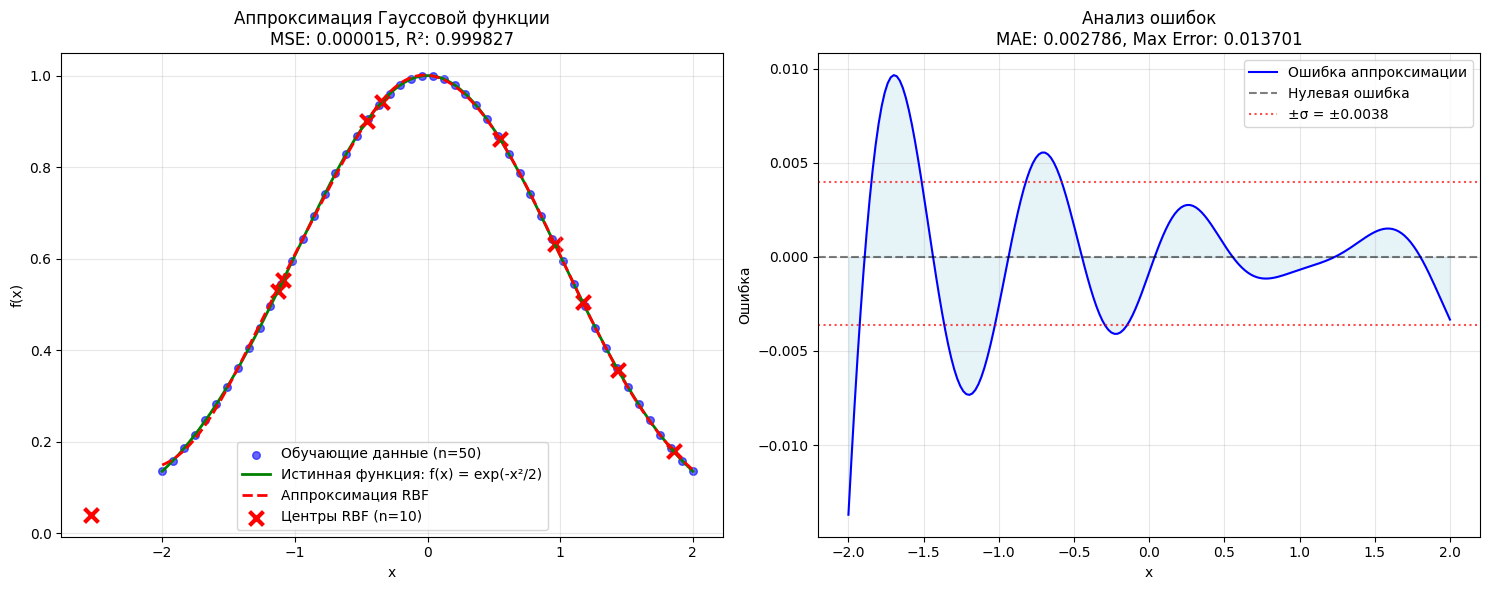


ТЕСТИРОВАНИЕ УСТОЙЧИВОСТИ К ШУМУ

Тестирование с уровнем шума: 0.0
ТЕСТИРОВАНИЕ RBF СЕТИ НА ГАУССОВОЙ ФУНКЦИИ
f(x) = exp(-x²/2)
Параметры сети: {'n_centers': 10, 'sigma': 0.5, 'learning_rate': 0.01, 'max_epochs': 800, 'rbf_type': 'gaussian'}
Количество обучающих точек: 50
Уровень шума: 0.0
Диапазон тестирования: (-2, 2)

МЕТРИКИ НА ОБУЧАЮЩИХ ДАННЫХ:
  MSE: 0.000026
  MAE: 0.004511
  R²: 0.999696
  RMSE: 0.005108
  Max Error: 0.009412

МЕТРИКИ НА ТЕСТОВЫХ ДАННЫХ:
  MSE: 0.000025
  MAE: 0.004446
  R²: 0.999698
  RMSE: 0.005035
  Max Error: 0.009412

ПРОВЕРКА КРИТЕРИЕВ КАЧЕСТВА:
  MSE < 0.01: 0.000025 - ✓ ПРОЙДЕН
  R² > 0.95: 0.999698 - ✓ ПРОЙДЕН
  MAE < 0.05: 0.004446 - ✓ ПРОЙДЕН

ОБЩИЙ РЕЗУЛЬТАТ: ✓ ВСЕ КРИТЕРИИ ПРОЙДЕНЫ

Тестирование с уровнем шума: 0.05
ТЕСТИРОВАНИЕ RBF СЕТИ НА ГАУССОВОЙ ФУНКЦИИ
f(x) = exp(-x²/2)
Параметры сети: {'n_centers': 10, 'sigma': 0.5, 'learning_rate': 0.01, 'max_epochs': 800, 'rbf_type': 'gaussian'}
Количество обучающих точек: 50
Уровень шума: 0.05
Диапазон т

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class RFBNetworkTest:
    """
    Тестирование RBF сети на Гауссовой функции f(x) = exp(-x²/2)
    """

    def __init__(self, n_samples=100, noise_level=0.0, test_range=(-2, 2)):
        """
        Инициализация теста

        Параметры:
        - n_samples: количество точек для генерации данных
        - noise_level: уровень шума (стандартное отклонение)
        - test_range: диапазон значений x для тестирования
        """
        self.n_samples = n_samples
        self.noise_level = noise_level
        self.test_range = test_range

    def generate_gaussian_data(self):
        """
        Генерирует данные для Гауссовой функции f(x) = exp(-x²/2)

        Возвращает:
        - X: входные данные
        - y: целевые значения
        """
        # Генерируем равномерно распределенные точки
        X = np.linspace(self.test_range[0], self.test_range[1], self.n_samples).reshape(-1, 1)
        x = X.flatten()

        # Гауссова функция: f(x) = exp(-x²/2)
        y = np.exp(-x**2 / 2)

        # Добавляем шум, если указан
        if self.noise_level > 0:
            noise = np.random.normal(0, self.noise_level, y.shape)
            y += noise

        return X, y

    def gaussian_function(self, x):
        """
        Истинная Гауссова функция без шума
        """
        return np.exp(-x**2 / 2)

    def calculate_metrics(self, y_true, y_pred):
        """
        Вычисляет метрики качества
        """
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mse)
        max_error = np.max(np.abs(y_true - y_pred))

        return {
            'MSE': mse,
            'MAE': mae,
            'R²': r2,
            'RMSE': rmse,
            'Max Error': max_error
        }

    def check_quality_criteria(self, metrics):
        """
        Проверяет соответствие критериям качества
        """
        print("\nПРОВЕРКА КРИТЕРИЕВ КАЧЕСТВА:")

        # Критерии качества
        mse_threshold = 0.01
        r2_threshold = 0.95
        mae_threshold = 0.05

        # Проверка MSE
        mse_pass = metrics['MSE'] < mse_threshold
        print(f"  MSE < {mse_threshold}: {metrics['MSE']:.6f} - {'✓ ПРОЙДЕН' if mse_pass else '✗ НЕ ПРОЙДЕН'}")

        # Проверка R²
        r2_pass = metrics['R²'] > r2_threshold
        print(f"  R² > {r2_threshold}: {metrics['R²']:.6f} - {'✓ ПРОЙДЕН' if r2_pass else '✗ НЕ ПРОЙДЕН'}")

        # Проверка MAE
        mae_pass = metrics['MAE'] < mae_threshold
        print(f"  MAE < {mae_threshold}: {metrics['MAE']:.6f} - {'✓ ПРОЙДЕН' if mae_pass else '✗ НЕ ПРОЙДЕН'}")

        # Общий результат
        all_pass = mse_pass and r2_pass and mae_pass
        print(f"\nОБЩИЙ РЕЗУЛЬТАТ: {'✓ ВСЕ КРИТЕРИИ ПРОЙДЕНЫ' if all_pass else '✗ ЕСТЬ НЕПРОЙДЕННЫЕ КРИТЕРИИ'}")

        return all_pass

    def test_rbf_network(self, rbf_network_params=None, plot_results=True):
        """
        Основной метод тестирования RBF сети на Гауссовой функции

        Параметры:
        - rbf_network_params: параметры для RBFNetwork
        - plot_results: отображать ли результаты

        Возвращает:
        - словарь с метриками качества
        """
        print("=" * 60)
        print("ТЕСТИРОВАНИЕ RBF СЕТИ НА ГАУССОВОЙ ФУНКЦИИ")
        print("f(x) = exp(-x²/2)")
        print("=" * 60)

        # Параметры RBF сети по умолчанию
        if rbf_network_params is None:
            rbf_network_params = {
                'n_centers': 10,
                'sigma': 0.5,
                'learning_rate': 0.01,
                'max_epochs': 800,
                'rbf_type': 'gaussian'
            }

        # Генерируем обучающие данные
        X_train, y_train = self.generate_gaussian_data()

        # Создаем и обучаем RBF сеть
        rbf_net = RBFNetwork(**rbf_network_params)
        rbf_net.fit(X_train, y_train)

        # Генерируем тестовые данные (более плотная сетка)
        X_test = np.linspace(self.test_range[0], self.test_range[1], 200).reshape(-1, 1)
        y_test_true = self.gaussian_function(X_test.flatten())

        # Получаем предсказания
        y_pred_train = rbf_net.predict(X_train)
        y_pred_test = rbf_net.predict(X_test)

        # Вычисляем метрики
        train_metrics = self.calculate_metrics(y_train, y_pred_train)
        test_metrics = self.calculate_metrics(y_test_true, y_pred_test)

        # Выводим результаты
        print(f"Параметры сети: {rbf_network_params}")
        print(f"Количество обучающих точек: {len(X_train)}")
        print(f"Уровень шума: {self.noise_level}")
        print(f"Диапазон тестирования: {self.test_range}")

        print("\nМЕТРИКИ НА ОБУЧАЮЩИХ ДАННЫХ:")
        for metric, value in train_metrics.items():
            print(f"  {metric}: {value:.6f}")

        print("\nМЕТРИКИ НА ТЕСТОВЫХ ДАННЫХ:")
        for metric, value in test_metrics.items():
            print(f"  {metric}: {value:.6f}")

        # Проверяем критерии качества
        quality_passed = self.check_quality_criteria(test_metrics)

        # Визуализация результатов
        if plot_results:
            self.plot_results(X_train, y_train, X_test, y_test_true, y_pred_test, rbf_net, test_metrics)

        return {
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'quality_passed': quality_passed,
            'network_params': rbf_network_params,
            'network': rbf_net
        }

    def plot_results(self, X_train, y_train, X_test, y_true, y_pred, rbf_net, metrics):
        """
        Визуализирует результаты тестирования
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # График 1: Сравнение аппроксимации
        ax1.scatter(X_train.flatten(), y_train, alpha=0.6, color='blue',
                   label=f'Обучающие данные (n={len(X_train)})', s=30)
        ax1.plot(X_test.flatten(), y_true, 'g-', linewidth=2,
                label='Истинная функция: f(x) = exp(-x²/2)')
        ax1.plot(X_test.flatten(), y_pred, 'r--', linewidth=2,
                label='Аппроксимация RBF')

        # Отмечаем центры RBF функций
        if hasattr(rbf_net, 'centers') and rbf_net.centers is not None:
            centers_x = rbf_net.centers.flatten()
            centers_y = self.gaussian_function(centers_x)
            ax1.scatter(centers_x, centers_y, color='red', marker='x', s=100,
                       linewidths=3, label=f'Центры RBF (n={len(centers_x)})')

        ax1.set_xlabel('x')
        ax1.set_ylabel('f(x)')
        ax1.set_title(f'Аппроксимация Гауссовой функции\nMSE: {metrics["MSE"]:.6f}, R²: {metrics["R²"]:.6f}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # График 2: Анализ ошибок
        errors = y_true - y_pred
        ax2.plot(X_test.flatten(), errors, 'b-', linewidth=1.5, label='Ошибка аппроксимации')
        ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5, label='Нулевая ошибка')
        ax2.fill_between(X_test.flatten(), errors, alpha=0.3, color='lightblue')

        # Статистика ошибок
        error_std = np.std(errors)
        error_mean = np.mean(errors)
        ax2.axhline(y=error_mean + error_std, color='r', linestyle=':', alpha=0.7,
                   label=f'±σ = ±{error_std:.4f}')
        ax2.axhline(y=error_mean - error_std, color='r', linestyle=':', alpha=0.7)

        ax2.set_xlabel('x')
        ax2.set_ylabel('Ошибка')
        ax2.set_title(f'Анализ ошибок\nMAE: {metrics["MAE"]:.6f}, Max Error: {metrics["Max Error"]:.6f}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def test_with_noise(self, noise_levels=[0.0, 0.05, 0.1]):
        """
        Тестирование устойчивости к шуму
        """
        print("\n" + "=" * 60)
        print("ТЕСТИРОВАНИЕ УСТОЙЧИВОСТИ К ШУМУ")
        print("=" * 60)

        results = []

        for noise in noise_levels:
            print(f"\nТестирование с уровнем шума: {noise}")

            # Создаем новый экземпляр с шумом
            test_with_noise = RFBNetworkTest(
                n_samples=self.n_samples,
                noise_level=noise,
                test_range=self.test_range
            )

            # Запускаем тестирование
            result = test_with_noise.test_rbf_network(plot_results=False)

            results.append({
                'Уровень шума': noise,
                'MSE': result['test_metrics']['MSE'],
                'R²': result['test_metrics']['R²'],
                'MAE': result['test_metrics']['MAE'],
                'Критерии пройдены': result['quality_passed']
            })

        # Выводим сводную таблицу
        print("\nВЛИЯНИЕ ШУМА НА КАЧЕСТВО АППРОКСИМАЦИИ:")
        print("-" * 60)
        for result in results:
            print(f"Шум: {result['Уровень шума']:.2f} | "
                  f"MSE: {result['MSE']:.6f} | "
                  f"R²: {result['R²']:.6f} | "
                  f"MAE: {result['MAE']:.6f} | "
                  f"Статус: {'✓' if result['Критерии пройдены'] else '✗'}")

        return results

# Пример использования
def run_gaussian_test():
    """
    Основная функция для запуска теста Гауссовой функции
    """
    # Создаем тест
    gaussian_test = RFBNetworkTest(
        n_samples=50,      # количество обучающих точек
        noise_level=0.0,   # без шума для точного тестирования
        test_range=(-2, 2) # диапазон тестирования
    )

    # Параметры RBF сети, оптимальные для Гауссовой функции
    rbf_params = {
        'n_centers': 10,
        'sigma': 0.5,
        'learning_rate': 0.01,
        'max_epochs': 800,
        'rbf_type': 'gaussian'
    }

    # Запускаем основной тест
    result = gaussian_test.test_rbf_network(rbf_params, plot_results=True)

    # Дополнительно тестируем устойчивость к шуму
    noise_results = gaussian_test.test_with_noise([0.0, 0.05, 0.1, 0.2])

    print("\n" + "=" * 60)
    print("ТЕСТИРОВАНИЕ ЗАВЕРШЕНО")
    print("=" * 60)

    return gaussian_test, result, noise_results

if __name__ == "__main__":
    # Запуск теста
    test, result, noise_results = run_gaussian_test()

### Функция для демонстрации различных типов радиальных базисных функций

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def demonstrate_rbf_types():
    """
    Демонстрирует различные типы радиальных базисных функций
    и их влияние на форму активаций с подробными пояснениями
    """

    def apply_rbf(r, rbf_type, sigma=1.0, alpha=0.5, beta=0.5):
        """
        Применяет различные типы радиальных базисных функций
        """
        r = np.abs(r)  # Работаем с абсолютными значениями расстояния

        if rbf_type == 'linear':
            return r
        elif rbf_type == 'gaussian':
            return np.exp(-(r**2) / (2 * sigma**2))
        elif rbf_type == 'thin_plate_spline':
            # Избегаем логарифма от нуля
            r_safe = np.where(r == 0, 1e-10, r)
            return (r**2) * np.log(r_safe)
        elif rbf_type == 'logistic':
            return 1 / (1 + np.exp((r**2) / (sigma**2)))
        elif rbf_type == 'hardy_multiquadric':
            return 1 / ((r**2 + sigma**2)**alpha)
        elif rbf_type == 'multiquadric':
            return (r**2 + sigma**2)**beta
        elif rbf_type == 'dsp_kernel':
            return 1 / (1 + (r**2) / (sigma**2))
        elif rbf_type == 'proposed_quadratic':
            return np.maximum(0, 1 - (r**2) / (sigma**2))
        else:
            raise ValueError(f"Неизвестный тип RBF: {rbf_type}")

    # Диапазон для визуализации
    r = np.linspace(-3, 3, 1000)
    r_abs = np.abs(r)

    # Параметры RBF функций
    sigma = 1.0
    alpha = 0.5
    beta = 0.5

    # Определяем типы функций и их описания
    rbf_functions = [
        ('linear', 'Линейная', 'h(r) = r', 'blue'),
        ('gaussian', 'Гауссова', f'h(r) = exp(-r²/2σ²), σ={sigma}', 'orange'),
        ('thin_plate_spline', 'Thin-plate Spline', 'h(r) = r² ln r', 'green'),
        ('logistic', 'Логистическая', f'h(r) = 1/(1+exp(r²/σ²)), σ={sigma}', 'red'),
        ('hardy_multiquadric', 'Hardy Multiquadric', f'h(r) = 1/(r²+σ²)^α, α={alpha}', 'purple'),
        ('multiquadric', 'Multiquadric', f'h(r) = (r²+σ²)^β, β={beta}', 'brown'),
        ('dsp_kernel', 'DSP Kernel', f'h(r) = 1/(1+r²/σ²), σ={sigma}', 'pink'),
        ('proposed_quadratic', 'Предложенная квадратичная', f'h(r) = max(0, 1-r²/σ²), σ={sigma}', 'gray')
    ]

    # Создаем фигуру с улучшенным дизайном
    fig = plt.figure(figsize=(20, 16))

    # График 1: Основные RBF функции (нормализованный масштаб)
    ax1 = plt.subplot(2, 3, 1)

    # Выбираем наиболее важные функции для лучшей читаемости
    main_functions = [
        ('gaussian', 'Гауссова', 'orange'),
        ('logistic', 'Логистическая', 'red'),
        ('dsp_kernel', 'DSP Kernel', 'blue'),
        ('proposed_quadratic', 'Предложенная квадратичная', 'green')
    ]

    for rbf_type, name, color in main_functions:
        values = apply_rbf(r_abs, rbf_type, sigma, alpha, beta)
        plt.plot(r, values, label=name, linewidth=3, color=color)

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Расстояние от центра (r)', fontsize=11, fontweight='bold')
    plt.ylabel('Значение активации h(r)', fontsize=11, fontweight='bold')
    plt.title('Основные RBF функции\n(локализованные типы)',
              fontsize=12, fontweight='bold', pad=15)
    plt.legend(fontsize=10)
    plt.xlim(-3, 3)
    plt.ylim(-0.1, 1.1)

    # График 2: Функции с неограниченным ростом (отдельный масштаб)
    ax2 = plt.subplot(2, 3, 2)

    growing_functions = [
        ('linear', 'Линейная', 'blue'),
        ('thin_plate_spline', 'Thin-plate Spline', 'green'),
        ('multiquadric', 'Multiquadric', 'brown')
    ]

    r_small = np.linspace(-2, 2, 500)  # Меньший диапазон для лучшей видимости

    for rbf_type, name, color in growing_functions:
        values = apply_rbf(np.abs(r_small), rbf_type, sigma, alpha, beta)
        if rbf_type == 'thin_plate_spline':
            # Ограничиваем значения для лучшей визуализации
            values = np.clip(values, -10, 10)
        plt.plot(r_small, values, label=name, linewidth=3, color=color)

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Расстояние от центра (r)', fontsize=11, fontweight='bold')
    plt.ylabel('Значение активации h(r)', fontsize=11, fontweight='bold')
    plt.title('RBF функции с ростом\n(неограниченные типы)',
              fontsize=12, fontweight='bold', pad=15)
    plt.legend(fontsize=10)
    plt.xlim(-2, 2)

    # График 3: Влияние параметра sigma для Гауссовой функции
    ax3 = plt.subplot(2, 3, 3)

    sigmas = [0.3, 0.7, 1.0, 1.5, 2.0]
    colors = ['darkred', 'red', 'orange', 'blue', 'darkblue']

    for sigma_val, color in zip(sigmas, colors):
        values = apply_rbf(r_abs, 'gaussian', sigma_val, alpha, beta)
        plt.plot(r, values, label=f'σ = {sigma_val}', linewidth=2.5, color=color)

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Расстояние от центра (r)', fontsize=11, fontweight='bold')
    plt.ylabel('Значение активации', fontsize=11, fontweight='bold')
    plt.title('Влияние параметра σ\n(Гауссова функция)',
              fontsize=12, fontweight='bold', pad=15)
    plt.legend(fontsize=10)
    plt.xlim(-3, 3)
    plt.ylim(-0.05, 1.05)

    # График 4: Сравнение Hardy Multiquadric с разными параметрами
    ax4 = plt.subplot(2, 3, 4)

    alphas = [0.2, 0.5, 1.0, 1.5]
    colors = ['purple', 'darkviolet', 'mediumorchid', 'plum']

    for alpha_val, color in zip(alphas, colors):
        values = apply_rbf(r_abs, 'hardy_multiquadric', sigma, alpha_val, beta)
        plt.plot(r, values, label=f'α = {alpha_val}', linewidth=2.5, color=color)

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Расстояние от центра (r)', fontsize=11, fontweight='bold')
    plt.ylabel('Значение активации', fontsize=11, fontweight='bold')
    plt.title('Hardy Multiquadric\nс разными параметрами α',
              fontsize=12, fontweight='bold', pad=15)
    plt.legend(fontsize=10)
    plt.xlim(-3, 3)

    # График 5: Логарифмический масштаб для демонстрации убывания
    ax5 = plt.subplot(2, 3, 5)

    r_log = np.linspace(0.1, 5, 500)

    log_functions = [
        ('gaussian', 'Гауссова', 'orange'),
        ('logistic', 'Логистическая', 'red'),
        ('hardy_multiquadric', 'Hardy Multiquadric', 'purple'),
        ('dsp_kernel', 'DSP Kernel', 'blue')
    ]

    for rbf_type, name, color in log_functions:
        values = apply_rbf(r_log, rbf_type, sigma, alpha, beta)
        # Избегаем логарифма от нуля
        values_safe = np.maximum(values, 1e-10)
        plt.semilogy(r_log, values_safe, label=name, linewidth=2.5, color=color)

    plt.grid(True, alpha=0.3)
    plt.xlabel('Расстояние от центра (r)', fontsize=11, fontweight='bold')
    plt.ylabel('log(Значение активации)', fontsize=11, fontweight='bold')
    plt.title('Скорость убывания функций\n(логарифмический масштаб)',
              fontsize=12, fontweight='bold', pad=15)
    plt.legend(fontsize=10)
    plt.xlim(0.1, 5)

    # График 6: Сравнение производных (градиентов)
    ax6 = plt.subplot(2, 3, 6)

    # Вычисляем численные производные
    dr = 0.01
    r_grad = np.linspace(0.1, 3, 300)

    gradient_functions = [
        ('gaussian', 'Гауссова', 'orange'),
        ('logistic', 'Логистическая', 'red'),
        ('dsp_kernel', 'DSP Kernel', 'blue')
    ]

    for rbf_type, name, color in gradient_functions:
        values_plus = apply_rbf(r_grad + dr/2, rbf_type, sigma, alpha, beta)
        values_minus = apply_rbf(r_grad - dr/2, rbf_type, sigma, alpha, beta)
        gradient = (values_plus - values_minus) / dr
        plt.plot(r_grad, gradient, label=f'∇{name}', linewidth=2.5, color=color)

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.8)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Расстояние от центра (r)', fontsize=11, fontweight='bold')
    plt.ylabel('Производная dh/dr', fontsize=11, fontweight='bold')
    plt.title('Градиенты RBF функций\n(скорость изменения)',
              fontsize=12, fontweight='bold', pad=15)
    plt.legend(fontsize=10)
    plt.xlim(0.1, 3)

    # Улучшенное размещение подграфиков
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.35, wspace=0.3)
    plt.show()

    # Подробная информационная таблица
    print("\n" + "="*100)
    print("ПОДРОБНОЕ СРАВНЕНИЕ РАДИАЛЬНЫХ БАЗИСНЫХ ФУНКЦИЙ")
    print("="*100)

    print("\n1. ЛОКАЛИЗОВАННЫЕ ФУНКЦИИ (убывают с расстоянием):")
    print("-" * 60)
    print("   Гауссова: h(r) = exp(-r²/2σ²)")
    print("   • Самая популярная в машинном обучении")
    print("   • Гладкая, бесконечно дифференцируемая")
    print("   • Быстро убывает к нулю")
    print("   • Хорошо подходит для аппроксимации гладких функций")

    print("\n   Логистическая: h(r) = 1/(1+exp(r²/σ²))")
    print("   • Ограничена между 0 и 1")
    print("   • Монотонно убывающая")
    print("   • Подходит для задач классификации")
    print("   • Вычислительно стабильная")

    print("\n   DSP Kernel: h(r) = 1/(1+r²/σ²)")
    print("   • Рациональная функция")
    print("   • Вычислительно эффективная")
    print("   • Хороший компромисс между локализацией и гладкостью")

    print("\n   Предложенная квадратичная: h(r) = max(0, 1-r²/σ²)")
    print("   • Компактный носитель (равна 0 за пределами σ)")
    print("   • Обеспечивает разреженность вычислений")
    print("   • Простая для вычисления")

    print("\n   Hardy Multiquadric: h(r) = 1/(r²+σ²)^α")
    print("   • Обратная мультиквадратичная функция")
    print("   • Численно стабильная")
    print("   • Параметр α контролирует скорость убывания")

    print("\n2. НЕОГРАНИЧЕННЫЕ ФУНКЦИИ (растут с расстоянием):")
    print("-" * 60)
    print("   Линейная: h(r) = r")
    print("   • Простейшая функция")
    print("   • Не имеет локализации")
    print("   • Редко используется на практике")

    print("\n   Thin-plate Spline: h(r) = r²ln(r)")
    print("   • Классическая в теории интерполяции")
    print("   • Минимизирует энергию изгиба")
    print("   • Используется в геометрическом моделировании")

    print("\n   Multiquadric: h(r) = (r²+σ²)^β")
    print("   • Растет степенным образом")
    print("   • Может привести к плохой обусловленности матриц")
    print("   • Требует осторожного выбора параметров")

    print("\n3. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
    print("-" * 60)
    print("   -> Для аппроксимации гладких функций: Гауссова")
    print("   -> Для задач классификации: Логистическая")
    print("   -> Для быстрых вычислений: DSP Kernel")
    print("   -> Для разреженных вычислений: Предложенная квадратичная")
    print("   -> Для интерполяции: Thin-plate Spline")
    print("   -> Для численной стабильности: Hardy Multiquadric")

    print("\n4. ВЛИЯНИЕ ПАРАМЕТРОВ:")
    print("-" * 60)
    print("   σ (sigma) - ширина функции:")
    print("   • Малое σ -> узкие, острые функции")
    print("   • Большое σ -> широкие, пологие функции")
    print("   • Влияет на способность к обобщению")

    print("\n   α, β - степенные параметры:")
    print("   • Контролируют скорость роста/убывания")
    print("   • Влияют на гладкость аппроксимации")
    print("   • Требуют экспериментального подбора")

    print("="*100)

### Функция для проведений экспериментов с разными параметрами RBF-сети

In [ ]:
def experiment_with_rbf(X, y, n_centers_list, sigma_list, X_test=None, y_test=None):
    """
    Проводит эксперименты с разными параметрами RBF-сети

    Параметры:
    - X, y: обучающие данные
    - n_centers_list: список количества центров для тестирования
    - sigma_list: список значений сигмы для тестирования
    - X_test, y_test: тестовые данные (необязательно)

    Возвращает:
    - DataFrame с результатами экспериментов
    """
    import pandas as pd

    results = []

    for n_centers in n_centers_list:
        for sigma in sigma_list:
            # Создаем и обучаем модель
            model = RBFNetwork(n_centers=n_centers, sigma=sigma)
            model.fit(X, y)

            # Вычисляем ошибки
            train_pred = model.predict(X)
            train_mse = np.mean((train_pred - y) ** 2)

            result = {
                'n_centers': n_centers,
                'sigma': sigma,
                'train_mse': train_mse
            }

            # Если есть тестовые данные
            if X_test is not None and y_test is not None:
                test_pred = model.predict(X_test)
                test_mse = np.mean((test_pred - y_test) ** 2)
                result['test_mse'] = test_mse

            results.append(result)

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)
    return results_df

### Функция для визуализации результатов экспериментов

In [ ]:
def visualize_experiment_results(results_df, test_data_available=False):
    """
    Визуализирует результаты экспериментов
    """
    n_centers_list = sorted(results_df['n_centers'].unique())
    sigma_list = sorted(results_df['sigma'].unique())

    # Создаем фигуру
    fig, ax = plt.subplots(1, 2 if test_data_available else 1, figsize=(16, 8 if test_data_available else 6))

    if not test_data_available:
        ax = [ax]

    # График зависимости ошибки от количества центров
    for sigma in sigma_list:
        subset = results_df[results_df['sigma'] == sigma]
        ax[0].plot(subset['n_centers'], subset['train_mse'], 'o-', label=f'sigma={sigma}')

    ax[0].set_xlabel('Количество центров')
    ax[0].set_ylabel('MSE на обучающей выборке')
    ax[0].set_title('Зависимость ошибки от количества центров')
    ax[0].legend()
    ax[0].grid(True)

    if test_data_available:
        # График сравнения ошибок на обучающей и тестовой выборках
        for sigma in sigma_list:
            subset = results_df[results_df['sigma'] == sigma]
            ax[1].plot(subset['n_centers'], subset['train_mse'], 'o-', label=f'train, sigma={sigma}')
            ax[1].plot(subset['n_centers'], subset['test_mse'], 'x--', label=f'test, sigma={sigma}')

        ax[1].set_xlabel('Количество центров')
        ax[1].set_ylabel('MSE')
        ax[1].set_title('Сравнение обучающей и тестовой ошибок')
        ax[1].legend()
        ax[1].grid(True)

    plt.tight_layout()
    plt.show()

### Генерация демонстрационных данных для RBF-сети

In [ ]:
def generate_demo_data(n_samples=100, noise=0.1, func_type='sin'):
    """
    Генерирует демонстрационные данные для RBF-сети

    Параметры:
    - n_samples: количество точек данных
    - noise: уровень шума
    - func_type: тип функции ('sin', 'exp', 'quadratic', 'complex')

    Возвращает:
    - X: входные данные
    - y: целевые значения
    """
    if func_type == 'sin':
        X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
        y = np.sin(X.flatten()) + noise * np.random.randn(n_samples)
    elif func_type == 'exp':
        X = np.linspace(-2, 2, n_samples).reshape(-1, 1)
        y = np.exp(-X.flatten()**2) + noise * np.random.randn(n_samples)
    elif func_type == 'quadratic':
        # Квадратичная функция: y = ax² + bx + c
        X = np.linspace(-3, 3, n_samples).reshape(-1, 1)
        y = 0.5 * X.flatten()**2 - 1.5 * X.flatten() + 2 + noise * np.random.randn(n_samples)
    elif func_type == '2d':
        # 2D данные для регрессии
        from sklearn.datasets import make_friedman2
        X, y = make_friedman2(n_samples=n_samples, noise=noise, random_state=42)
        # Ограничиваем до первых двух признаков для наглядности
        X = X[:, :2]
    elif func_type == 'classification':
        # 2D данные для классификации
        from sklearn.datasets import make_circles
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=42)
    else:  # complex
        X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
        y = np.sin(X.flatten()) * np.exp(-0.1 * X.flatten()**2) + noise * np.random.randn(n_samples)

    return X, y

### Генерация демонстрационных данных для RBF-сети (advanced)

In [ ]:
def generate_advanced_demo_data(n_samples=200, noise=0.1, func_type='multimodal'):
    """
    Генерирует более сложные демонстрационные данные для RBF-сети

    Параметры:
    - n_samples: количество точек данных
    - noise: уровень шума
    - func_type: тип функции

    Типы функций:
    - 'multimodal': многомодальная функция
    - 'discontinuous': разрывная функция
    - 'multidimensional': многомерная функция (3D)
    - 'noisy_peaks': функция с шумными всплесками
    - 'complex_3d': сложная 3D поверхность
    """
    if func_type == 'multimodal':
        X = np.linspace(-8, 8, n_samples).reshape(-1, 1)
        y = np.sin(X.flatten()) + 0.5 * np.sin(3 * X.flatten()) + noise * np.random.randn(n_samples)

    elif func_type == 'discontinuous':
        X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
        y = np.zeros(n_samples)
        mask1 = X.flatten() < -2
        mask2 = (X.flatten() >= -2) & (X.flatten() < 1)
        mask3 = X.flatten() >= 1
        y[mask1] = -1 + noise * np.random.randn(np.sum(mask1))
        y[mask2] = np.sin(X.flatten()[mask2] * 2) + noise * np.random.randn(np.sum(mask2))
        y[mask3] = 1 + 0.5 * np.sin(X.flatten()[mask3]) + noise * np.random.randn(np.sum(mask3))

    elif func_type == 'multidimensional':
        # 3D данные для регрессии
        from sklearn.datasets import make_friedman3
        X, y = make_friedman3(n_samples=n_samples, noise=noise, random_state=42)
        # Ограничиваем до первых трех признаков для наглядности
        X = X[:, :3]

    elif func_type == 'noisy_peaks':
        X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
        base = np.sin(X.flatten()) * np.exp(-0.1 * X.flatten()**2)
        # Добавляем случайные всплески
        peaks = np.zeros(n_samples)
        for _ in range(10):  # 10 случайных всплесков
            pos = np.random.randint(0, n_samples)
            width = np.random.randint(5, 20)
            height = np.random.uniform(1, 3)
            # Ограничиваем диапазон индексов
            start = max(0, pos - width // 2)
            end = min(n_samples, pos + width // 2)
            peaks[start:end] = height * np.exp(-0.5 * ((np.arange(start, end) - pos) / (width / 5))**2)
        y = base + peaks + noise * np.random.randn(n_samples)

    elif func_type == 'complex_3d':
        # Создаем сетку точек в 2D пространстве
        x = np.linspace(-3, 3, int(np.sqrt(n_samples)))
        y = np.linspace(-3, 3, int(np.sqrt(n_samples)))
        xx, yy = np.meshgrid(x, y)
        X = np.column_stack([xx.ravel(), yy.ravel()])

        # Сложная функция от двух переменных
        z = np.sin(np.sqrt(xx**2 + yy**2)) + 0.1 * xx * yy + np.exp(-0.1 * (xx**2 + yy**2)) * np.cos(xx * yy)
        z = z.ravel() + noise * np.random.randn(X.shape[0])

        return X, z

    else:  # default - return simple noisy function
        X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
        y = 0.5 * X.flatten()**2 + np.sin(X.flatten() * 3) + noise * np.random.randn(n_samples)

    return X, y

### Визуализация метрик

In [ ]:
def visualize_metrics(metrics_dict, title="Метрики качества аппроксимации"):
    """
    Визуализирует метрики качества в виде графика
    """
    # Создаем график
    fig, ax = plt.subplots(figsize=(12, 6))

    # Извлекаем метрики и их значения
    metrics = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    # Строим столбчатую диаграмму
    bars = ax.bar(metrics, values, color='skyblue')

    # Добавляем значения над столбцами
    for bar in bars:
        height = bar.get_height()
        if height < 1e-10:  # Для очень маленьких значений
            ax.text(bar.get_x() + bar.get_width()/2., 0.01,
                   f'{height:.2e}', ha='center', va='bottom', rotation=45)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02 * max(values),
                   f'{height:.4f}', ha='center', va='bottom', rotation=0)

    ax.set_title(title)
    ax.set_ylabel('Значение')

    # Поворачиваем надписи для более удобного чтения
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    return fig

###  Демонстрация формирования радиальных базисных функций

In [ ]:
def demo_rbf_formation():
    """
    Демонстрация формирования радиальных базисных функций
    с подробными объяснениями для образовательных целей
    """
    print("ДЕМОНСТРАЦИЯ: Формирование радиально-базисных функций")
    print("=" * 60)
    print("Эта демонстрация покажет, как RBF-сеть создает и использует")
    print("радиальные базисные функции для аппроксимации данных.\n")

    # === 1D ДЕМОНСТРАЦИЯ ===
    print("ЧАСТЬ 1: ОДНОМЕРНЫЙ СЛУЧАЙ (1D)")
    print("-" * 40)

    # Генерируем простые данные
    print("Генерируем тестовые данные (синусоида с шумом)...")
    X, y = generate_demo_data(n_samples=100, noise=0.1, func_type='sin')

    print(f"✓ Создано {len(X)} точек данных")
    print(f"✓ Диапазон X: от {X.min():.2f} до {X.max():.2f}")
    print(f"✓ Диапазон Y: от {y.min():.2f} до {y.max():.2f}")

    # Создаем и обучаем модель
    print("\nСоздаем RBF-сеть...")
    model = RBFNetwork(n_centers=5, sigma=0.5, rbf_type='gaussian')
    print(f"✓ Конфигурация: {model.n_centers} RBF-нейронов, sigma={model.sigma}")

    print("Обучаем сеть на данных...")
    model.fit(X, y)
    print("✓ Обучение завершено!")

    # Показываем расположение центров
    print(f"\n Центры RBF-функций расположены в точках:")
    for i, center in enumerate(model.centers):
        print(f"   RBF {i+1}: x = {center.item():.3f}")

    # Визуализируем RBF функции с обучающими данными
    print("\n Строим детальную визуализацию...")
    model.visualize_rbf_functions(X, feature_names=['X'], X_train=X, y_train=y)

    # === 2D ДЕМОНСТРАЦИЯ ===
    print("\n" + "=" * 60)
    print(" ЧАСТЬ 2: ДВУМЕРНЫЙ СЛУЧАЙ (2D)")
    print("-" * 40)

    print("Генерируем 2D данные для регрессии...")
    X_2d, y_2d = generate_demo_data(n_samples=200, noise=0.1, func_type='2d')

    print(f"✓ Создано {len(X_2d)} точек данных")
    print(f"✓ Диапазон X1: от {X_2d[:, 0].min():.2f} до {X_2d[:, 0].max():.2f}")
    print(f"✓ Диапазон X2: от {X_2d[:, 1].min():.2f} до {X_2d[:, 1].max():.2f}")
    print(f"✓ Диапазон Y: от {y_2d.min():.2f} до {y_2d.max():.2f}")

    # Создаем и обучаем 2D модель
    print("\nСоздаем 2D RBF-сеть...")
    model_2d = RBFNetwork(n_centers=9, sigma=0.5, rbf_type='gaussian')
    print(f"✓ Конфигурация: {model_2d.n_centers} RBF-нейронов, sigma={model_2d.sigma}")

    print("Обучаем сеть на 2D данных...")
    model_2d.fit(X_2d, y_2d)
    print("✓ Обучение завершено!")

    # Показываем расположение центров в 2D
    print(f"\n Центры RBF-функций в 2D пространстве:")
    for i, center in enumerate(model_2d.centers):
        print(f"   RBF {i+1}: ({center[0]:.3f}, {center[1]:.3f})")

    # Визуализируем RBF функции в 2D с обучающими данными
    print("\n Строим 2D визуализацию...")
    model_2d.visualize_rbf_functions(X_2d, feature_names=['X1', 'X2'],
                                   X_train=X_2d, y_train=y_2d)

    # === ИТОГОВЫЕ ПОЯСНЕНИЯ ===
    print("\n" + "=" * 60)
    print(" ОБРАЗОВАТЕЛЬНЫЕ ВЫВОДЫ")
    print("-" * 40)
    print(" ЧТО МЫ УЗНАЛИ:")
    print("   1. RBF-функции создают 'области влияния' вокруг своих центров")
    print("   2. Каждая функция максимально активна в своем центре")
    print("   3. Итоговый результат = сумма всех RBF × их веса")
    print("   4. В 2D случае RBF создают 'холмы' активации")
    print("   5. Сеть автоматически выбирает центры и веса при обучении")

    print("\n ПРИНЦИП РАБОТЫ:")
    print("   • Новая точка данных 'активирует' ближайшие RBF-функции")
    print("   • Чем ближе точка к центру RBF, тем сильнее активация")
    print("   • Итоговый ответ = взвешенная сумма всех активаций")
    print("   • Это позволяет аппроксимировать сложные функции!")

    print(f"\n Демонстрация завершена!")
    print(f"   Изучено {model.n_centers} RBF-функций в 1D и {model_2d.n_centers} в 2D")

### Демонстрация экспериментов с разным количеством нейронов и шириной функций

In [ ]:
def demo_experiment_neurons_width():
    """
    Демонстрация экспериментов с разным количеством нейронов и шириной функций
    """
    print("=" * 70)
    print("ЭКСПЕРИМЕНТЫ С КОЛИЧЕСТВОМ НЕЙРОНОВ И ШИРИНОЙ ФУНКЦИЙ")
    print("=" * 70)

    print("\n ЧТО МЫ ИЗУЧАЕМ:")
    print("   • Как количество нейронов влияет на качество аппроксимации")
    print("   • Как ширина радиальных функций (параметр σ) влияет на обучение")
    print("   • Поиск оптимального баланса между точностью и обобщением")

    print("\n УСЛОВИЯ ЭКСПЕРИМЕНТА:")
    print("   • Функция: сложная нелинейная функция с шумом")
    print("   • Размер выборки: 200 точек (140 для обучения, 60 для тестирования)")
    print("   • Уровень шума: 20% для имитации реальных данных")

    print("\n ПАРАМЕТРЫ ДЛЯ ИССЛЕДОВАНИЯ:")
    print("   • Количество центров (нейронов): 3, 5, 7, 10, 15, 20")
    print("     - Малое количество: может быть недостаточно для сложных функций")
    print("     - Большое количество: может привести к переобучению")
    print("   • Ширина функций (σ): 0.1, 0.5, 1.0, 2.0")
    print("     - Малая σ: узкие функции, локальное влияние")
    print("     - Большая σ: широкие функции, глобальное влияние")

    print("\n Начинаем эксперимент...")
    print("-" * 50)

    # Генерируем данные
    print("Генерация демонстрационных данных...")
    X, y = generate_demo_data(n_samples=200, noise=0.2, func_type='complex')

    # Разделяем на обучающую и тестовую выборки
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print(f"✓ Данные разделены: {len(X_train)} для обучения, {len(X_test)} для тестирования")

    # Задаем параметры для экспериментов
    n_centers_list = [3, 5, 7, 10, 15, 20]
    sigma_list = [0.1, 0.5, 1.0, 2.0]

    print(f"✓ Будет протестировано {len(n_centers_list) * len(sigma_list)} комбинаций параметров")

    # Проводим эксперименты
    print("\nПроведение экспериментов (это может занять некоторое время)...")
    results = experiment_with_rbf(X_train, y_train, n_centers_list, sigma_list, X_test, y_test)

    print("\n РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ")
    print("=" * 50)

    # Визуализируем результаты
    visualize_experiment_results(results, test_data_available=True)

    # Выводим краткую сводку результатов
    print("\n СВОДКА РЕЗУЛЬТАТОВ:")
    print(f"   • Всего протестировано комбинаций: {len(results)}")
    print(f"   • Минимальная ошибка на тесте: {results['test_mse'].min():.6f}")
    print(f"   • Максимальная ошибка на тесте: {results['test_mse'].max():.6f}")
    print(f"   • Средняя ошибка на тесте: {results['test_mse'].mean():.6f}")

    # Находим лучшую комбинацию параметров
    best_idx = results['test_mse'].idxmin()
    best_params = results.iloc[best_idx]

    print(f"\n ЛУЧШИЕ ПАРАМЕТРЫ:")
    print(f"   • Количество центров: {int(best_params['n_centers'])}")
    print(f"   • Ширина функций (σ): {best_params['sigma']}")
    print(f"   • Ошибка на обучающей выборке: {best_params['train_mse']:.6f}")
    print(f"   • Ошибка на тестовой выборке: {best_params['test_mse']:.6f}")

    # Анализ переобучения
    overfit_ratio = best_params['test_mse'] / best_params['train_mse']
    if overfit_ratio > 2.0:
        print("Модель может переобучаться (тестовая ошибка >> обучающей)")
    elif overfit_ratio < 1.2:
        print("Модель хорошо обобщает (низкое переобучение)")
    else:
        print("Умеренное переобучение (нормально для сложных данных)")

    # Визуализируем лучшую модель
    print(f"\n ВИЗУАЛИЗАЦИЯ ЛУЧШЕЙ МОДЕЛИ")
    print("-" * 40)

    best_model = RBFNetwork(n_centers=int(best_params['n_centers']), sigma=best_params['sigma'])
    best_model.fit(X_train, y_train)

    # Предсказания на тестовой выборке
    y_pred = best_model.predict(X_test)

    plt.figure(figsize=(12, 8))

    # Основной график
    plt.subplot(2, 1, 1)
    plt.scatter(X_train, y_train, alpha=0.6, color='blue', s=30, label='Обучающие данные')
    plt.scatter(X_test, y_test, alpha=0.6, color='green', s=30, label='Тестовые данные')

    # Сортируем для корректного отображения линии
    sort_idx = np.argsort(X_test.flatten())
    plt.plot(X_test[sort_idx], y_pred[sort_idx], 'r-', linewidth=2, label='Предсказание RBF')

    plt.title(f'Лучшая модель: {int(best_params["n_centers"])} центров, σ={best_params["sigma"]}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График центров RBF функций
    plt.subplot(2, 1, 2)
    x_range = np.linspace(X.min(), X.max(), 300)
    rbf_outputs = []

    for i, center in enumerate(best_model.centers):
        rbf_output = np.exp(-((x_range - center) ** 2) / (2 * best_params['sigma'] ** 2))
        rbf_outputs.append(rbf_output)
        plt.plot(x_range, rbf_output, alpha=0.7, label=f'RBF {i+1}')

    plt.title('Радиальные базисные функции (центры и их влияние)')
    plt.xlabel('X')
    plt.ylabel('Активация RBF')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    print("\n ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
    print("-" * 40)

    # Анализ найденных параметров
    best_n_centers = int(best_params['n_centers'])
    best_sigma = best_params['sigma']

    if best_n_centers <= 5:
        print("   • Малое количество центров оказалось оптимальным")
        print("     - Простая модель с хорошим обобщением")
        print("     - Подходит для не очень сложных функций")
    elif best_n_centers <= 10:
        print("   • Умеренное количество центров показало лучший результат")
        print("     - Баланс между сложностью и обобщением")
        print("     - Оптимально для большинства задач")
    else:
        print("   • Большое количество центров потребовалось для точности")
        print("     - Сложная функция требует больше параметров")
        print("     - Следите за переобучением!")

    if best_sigma <= 0.5:
        print("   • Узкие RBF функции (малая σ) работают лучше")
        print("     - Локальное влияние каждого центра")
        print("     - Подходит для данных с резкими изменениями")
    else:
        print("   • Широкие RBF функции (большая σ) предпочтительнее")
        print("     - Глобальное влияние центров")
        print("     - Подходит для гладких функций")

    print(f"\n Полная таблица результатов:")
    print(results.round(6))

    print("\n Эксперимент завершен!")
    print("   Вы изучили влияние ключевых гиперпараметров RBF сетей")
    print("   и нашли оптимальную конфигурацию для данной задачи.")

### Демонстрация сравнения результатов на разных наборах данных

In [ ]:
def demo_dataset_comparison():
    """
    Демонстрация сравнения результатов на разных наборах данных
    """
    print("=" * 70)
    print("ДЕМОНСТРАЦИЯ: СРАВНЕНИЕ РЕЗУЛЬТАТОВ НА РАЗНЫХ НАБОРАХ ДАННЫХ")
    print("=" * 70)

    print("\nЦЕЛЬ ЭКСПЕРИМЕНТА:")
    print("Показать, как радиально-базисные нейронные сети справляются с аппроксимацией")
    print("различных типов функций и оценить их универсальность.")

    print("\nУСЛОВИЯ ЭКСПЕРИМЕНТА:")
    print("• Количество образцов: 200 (достаточно для обучения, но не избыточно)")
    print("• Уровень шума: 0.1 (умеренный шум, имитирующий реальные данные)")
    print("• Разделение данных: 70% обучение / 30% тестирование")
    print("• Количество RBF-центров: 7 (компромисс между точностью и переобучением)")
    print("• Ширина функций (σ): 0.5 (средняя ширина для универсальности)")

    print("\nТИПЫ ДАННЫХ ДЛЯ СРАВНЕНИЯ:")
    print("1. SIN - Периодическая функция (синус)")
    print("   Особенности: регулярные колебания, проверяет способность к интерполяции")

    print("2. EXP - Гауссова функция (e^(-x²))")
    print("   Особенности: колокообразная форма, быстрое затухание к краям")

    print("3. COMPLEX - Комбинированная функция (sin(x) * e^(-0.1x²))")
    print("   Особенности: сложная форма с модуляцией, наиболее сложная для аппроксимации")

    print("\nЧТО ПОКАЗЫВАЕТ ЭКСПЕРИМЕНТ:")
    print("• Train MSE - ошибка на обучающих данных (показывает качество подгонки)")
    print("• Test MSE - ошибка на тестовых данных (показывает способность к обобщению)")
    print("• Разность между Train и Test MSE указывает на переобучение")

    print("\nЗапуск эксперимента...")
    print("-" * 50)

    # Генерируем разные наборы данных
    datasets = {
        'sin': generate_demo_data(n_samples=200, noise=0.1, func_type='sin'),
        'exp': generate_demo_data(n_samples=200, noise=0.1, func_type='exp'),
        'complex': generate_demo_data(n_samples=200, noise=0.1, func_type='complex')
    }

    # Параметры модели
    n_centers = 7
    sigma = 0.5

    # Создаем подграфики
    fig, axes = plt.subplots(len(datasets), 1, figsize=(12, 4 * len(datasets)))

    results_summary = {}

    for i, (name, (X, y)) in enumerate(datasets.items()):
        print(f"\nОБРАБОТКА НАБОРА ДАННЫХ: {name.upper()}")

        # Разделяем на обучающую и тестовую выборки
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Создаем и обучаем модель
        model = RBFNetwork(n_centers=n_centers, sigma=sigma)
        print(f"  Обучение RBF-сети с {n_centers} центрами...")
        model.fit(X_train, y_train)

        # Предсказания
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Вычисляем ошибки
        train_mse = np.mean((y_train_pred - y_train) ** 2)
        test_mse = np.mean((y_test_pred - y_test) ** 2)

        # Вычисляем коэффициент детерминации R²
        train_r2 = 1 - (np.sum((y_train - y_train_pred) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2))
        test_r2 = 1 - (np.sum((y_test - y_test_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

        # Сохраняем результаты
        results_summary[name] = {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'overfitting': abs(test_mse - train_mse)
        }

        print(f"  ✓ Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
        print(f"  ✓ Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

        # Сортируем для корректного отображения линий
        train_sort_idx = np.argsort(X_train.flatten())
        test_sort_idx = np.argsort(X_test.flatten())

        # Строим график
        ax = axes[i]
        ax.scatter(X_train, y_train, alpha=0.6, s=30, label='Обучающие данные', color='blue')
        ax.scatter(X_test, y_test, alpha=0.6, s=30, label='Тестовые данные', color='magenta')
        ax.plot(X_train[train_sort_idx], y_train_pred[train_sort_idx], 'r-',
                linewidth=2.5, label='Предсказания (обуч.)', alpha=0.8)
        ax.plot(X_test[test_sort_idx], y_test_pred[test_sort_idx], 'g--',
                linewidth=2.5, label='Предсказания (тест)', alpha=0.8)

        ax.set_title(f'Набор "{name}" | Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f} | R²: {test_r2:.3f}',
                    fontsize=12, fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    plt.tight_layout()
    plt.show()

    # Анализ результатов
    print("\n" + "=" * 70)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("=" * 70)

    # Найдем лучший и худший результаты
    best_dataset = min(results_summary.keys(), key=lambda k: results_summary[k]['test_mse'])
    worst_dataset = max(results_summary.keys(), key=lambda k: results_summary[k]['test_mse'])
    most_overfitted = max(results_summary.keys(), key=lambda k: results_summary[k]['overfitting'])

    print(f"\n СВОДКА ПО КАЧЕСТВУ АППРОКСИМАЦИИ:")
    for name, results in results_summary.items():
        status = ""
        if name == best_dataset:
            status = "  ЛУЧШИЙ РЕЗУЛЬТАТ"
        elif name == worst_dataset:
            status = "  СЛОЖНЕЙШАЯ ЗАДАЧА"

        print(f"\n{name.upper()}{status}:")
        print(f"  • Ошибка на тесте: {results['test_mse']:.4f}")
        print(f"  • Качество R²: {results['test_r2']:.3f} ({'отлично' if results['test_r2'] > 0.9 else 'хорошо' if results['test_r2'] > 0.7 else 'удовлетворительно'})")
        print(f"  • Переобучение: {results['overfitting']:.4f} ({'низкое' if results['overfitting'] < 0.01 else 'умеренное' if results['overfitting'] < 0.05 else 'высокое'})")

    print(f"\n ВЫВОДЫ:")
    print(f"• Лучше всего сеть справилась с функцией '{best_dataset}'")
    print(f"• Наибольшие трудности вызвала функция '{worst_dataset}'")
    print(f"• Наибольшее переобучение наблюдается у '{most_overfitted}'")

    print(f"\n ИНТЕРПРЕТАЦИЯ:")
    print(f"• Низкое значение MSE указывает на хорошую точность аппроксимации")
    print(f"• R² близкое к 1.0 означает отличное качество модели")
    print(f"• Большая разность Train/Test MSE указывает на переобучение")
    print(f"• RBF-сети лучше работают с гладкими функциями")

    print(f"\n ПРАКТИЧЕСКОЕ ЗНАЧЕНИЕ:")
    print(f"• Эксперимент показывает универсальность RBF-сетей")
    print(f"• Демонстрирует важность выбора параметров под тип задачи")
    print(f"• Подтверждает необходимость контроля переобучения")

    print("\n" + "=" * 70)

### Cравнение результатов на разных наборах данных:

In [ ]:
def plot_dataset_results(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, title="Результаты аппроксимации"):
    """
    Визуализирует результаты аппроксимации на обучающей и тестовой выборках
    """
    plt.figure(figsize=(12, 8))

    # Если одномерные данные
    if X_train.shape[1] == 1:
        train_sort_idx = np.argsort(X_train.flatten())
        test_sort_idx = np.argsort(X_test.flatten())

        plt.scatter(X_train, y_train, alpha=0.5, label='Обучающие данные')
        plt.scatter(X_test, y_test, alpha=0.5, label='Тестовые данные')

        plt.plot(X_train[train_sort_idx], y_train_pred[train_sort_idx], 'r-',
                linewidth=2, label='Предсказания на обучающих данных')
        plt.plot(X_test[test_sort_idx], y_test_pred[test_sort_idx], 'g--',
                linewidth=2, label='Предсказания на тестовых данных')

    # Если двумерные данные
    elif X_train.shape[1] == 2:
        from mpl_toolkits.mplot3d import Axes3D

        # Создаем 3D график
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Обучающие данные
        ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='blue', alpha=0.5, label='Обучающие данные')

        # Тестовые данные
        ax.scatter(X_test[:, 0], X_test[:, 1], y_test, color='green', alpha=0.5, label='Тестовые данные')

        # Предсказания на тестовых данных
        ax.scatter(X_test[:, 0], X_test[:, 1], y_test_pred, color='red', alpha=0.5, label='Предсказания')

        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('y')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Расширенные эксперименты:

In [ ]:
def demo_advanced_experiments():
    """
    Демонстрация расширенных экспериментов с RBF-сетями
    """
    print("=== РАСШИРЕННЫЕ ЭКСПЕРИМЕНТЫ С RBF-СЕТЯМИ ===")
    print()
    print("ЦЕЛЬ ЭКСПЕРИМЕНТА:")
    print("Исследование возможностей радиально-базисных нейронных сетей")
    print("при работе со сложными функциями, которые трудно аппроксимировать.")
    print()
    print("ПОЧЕМУ ИМЕННО ЭТИ ТИПЫ ФУНКЦИЙ?")
    print("• Многомодальная функция - содержит несколько локальных максимумов/минимумов")
    print("  (проверяет способность сети улавливать сложные зависимости)")
    print("• Разрывная функция - имеет скачки и разрывы")
    print("  (проверяет способность сети работать с нестандартными данными)")
    print("• Функция с шумными всплесками - содержит случайные аномалии")
    print("  (проверяет устойчивость сети к выбросам и шуму)")
    print()
    print("ПАРАМЕТРЫ ЭКСПЕРИМЕНТА:")
    print("• Количество центров RBF: 5, 10, 15, 20, 30, 50")
    print("  (от простых до сложных моделей)")
    print("• Ширина RBF функций (σ): 0.1, 0.5, 1.0, 2.0")
    print("  (от узких до широких функций)")
    print("• Размер выборки: 300 точек (70% обучение, 30% тест)")
    print("  (достаточно для надежной оценки)")
    print()
    print("Начинаем эксперименты...")
    print("=" * 60)

    # Генерируем более сложные наборы данных
    print("\n ГЕНЕРАЦИЯ ТЕСТОВЫХ ДАННЫХ...")
    advanced_datasets = {
        'Многомодальная': generate_advanced_demo_data(n_samples=300, noise=0.1, func_type='multimodal'),
        'Разрывная': generate_advanced_demo_data(n_samples=300, noise=0.1, func_type='discontinuous'),
        'С шумными всплесками': generate_advanced_demo_data(n_samples=300, noise=0.1, func_type='noisy_peaks')
    }

    # Параметры для экспериментов
    n_centers_list = [5, 10, 15, 20, 30, 50]
    sigma_list = [0.1, 0.5, 1.0, 2.0]

    print(f"Сгенерированы {len(advanced_datasets)} типа сложных функций")
    print(f"Будет протестировано {len(n_centers_list) * len(sigma_list)} комбинаций параметров для каждой функции")

    # Для каждого набора данных проводим эксперименты
    all_results = {}
    best_params = {}
    best_metrics = {}

    for idx, (dataset_name, (X, y)) in enumerate(advanced_datasets.items(), 1):
        print(f"\n{'='*60}")
        print(f"ЭКСПЕРИМЕНТ {idx}/3: {dataset_name.upper()} ФУНКЦИЯ")
        print(f"{'='*60}")

        # Пояснение для каждого типа функции
        if dataset_name == 'Многомодальная':
            print("   ОПИСАНИЕ: Функция sin(x) + 0.5*sin(3x) с несколькими пиками и впадинами.")
            print("   Сложность: RBF-сети должны разместить центры так, чтобы покрыть все локальные особенности.")
            print("   Ожидание: Потребуется больше центров для точной аппроксимации.")
        elif dataset_name == 'Разрывная':
            print("   ОПИСАНИЕ: Кусочная функция с резкими скачками в точках x=-2 и x=1.")
            print("   Сложность: Разрывы создают проблемы для гладких функций аппроксимации.")
            print("   Ожидание: Узкие RBF (малое σ) могут дать лучший результат.")
        elif dataset_name == 'С шумными всплесками':
            print("   ОПИСАНИЕ: Базовая функция с добавленными случайными пиками.")
            print("   Сложность: Модель должна отличать истинную закономерность от шума.")
            print("   Ожидание: Средние значения параметров могут показать лучший баланс.")

        # Разделяем на обучающую и тестовую выборки
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        print(f"\n Размеры выборок:")
        print(f"   • Обучающая выборка: {len(X_train)} точек")
        print(f"   • Тестовая выборка: {len(X_test)} точек")
        print(f"   • Диапазон значений y: [{np.min(y):.3f}, {np.max(y):.3f}]")

        # Проводим эксперименты
        print(f"\n ПОИСК ОПТИМАЛЬНЫХ ПАРАМЕТРОВ...")
        print("   Тестируем все комбинации параметров методом перебора...")

        results = experiment_with_rbf(X_train, y_train, n_centers_list, sigma_list, X_test, y_test)
        all_results[dataset_name] = results

        # Находим лучшую комбинацию параметров
        best_idx = results['test_mse'].idxmin()
        best_params[dataset_name] = results.iloc[best_idx]

        print(f"\n РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:")
        print(f"   • Лучшие параметры: n_centers={int(best_params[dataset_name]['n_centers'])}, σ={best_params[dataset_name]['sigma']}")
        print(f"   • MSE на обучающей выборке: {best_params[dataset_name]['train_mse']:.6f}")
        print(f"   • MSE на тестовой выборке: {best_params[dataset_name]['test_mse']:.6f}")

        # Анализ результатов
        test_mse = best_params[dataset_name]['test_mse']
        train_mse = best_params[dataset_name]['train_mse']
        overfitting_ratio = test_mse / train_mse

        print(f"\n АНАЛИЗ КАЧЕСТВА:")
        if overfitting_ratio < 1.2:
            print(f"      Модель хорошо обобщает (отношение MSE тест/обучение: {overfitting_ratio:.2f})")
        elif overfitting_ratio < 2.0:
            print(f"      Небольшое переобучение (отношение MSE тест/обучение: {overfitting_ratio:.2f})")
        else:
            print(f"     Значительное переобучение (отношение MSE тест/обучение: {overfitting_ratio:.2f})")

        # Создаем лучшую модель и вычисляем расширенные метрики
        best_model = RBFNetwork(
            n_centers=int(best_params[dataset_name]['n_centers']),
            sigma=best_params[dataset_name]['sigma']
        )
        best_model.fit(X_train, y_train)

        # Предсказания
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Вычисляем расширенные метрики
        train_metrics = RBFNetwork.calculate_metrics(y_train, y_train_pred)
        test_metrics = RBFNetwork.calculate_metrics(y_test, y_test_pred)
        best_metrics[dataset_name] = {'train': train_metrics, 'test': test_metrics}

        # Выводим таблицу метрик с пояснениями
        print(f"\n  ДЕТАЛЬНЫЕ МЕТРИКИ КАЧЕСТВА:")
        print(f"\n   Обучающая выборка:")
        for metric, value in train_metrics.items():
            print(f"   • {metric.upper()}: {value:.6f}")

        print(f"\n   Тестовая выборка:")
        for metric, value in test_metrics.items():
            print(f"   • {metric.upper()}: {value:.6f}")

        # Интерпретация метрик
        print(f"\n  ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
        r2_score = test_metrics.get('r2', 0)
        if r2_score > 0.9:
            print(f"     Отличное качество аппроксимации (R² = {r2_score:.3f})")
        elif r2_score > 0.8:
            print(f"     Хорошее качество аппроксимации (R² = {r2_score:.3f})")
        elif r2_score > 0.6:
            print(f"      Удовлетворительное качество (R² = {r2_score:.3f})")
        else:
            print(f"    Низкое качество аппроксимации (R² = {r2_score:.3f})")

        # Визуализируем метрики
        print(f"\n  Построение графиков метрик...")
        visualize_metrics(test_metrics, title=f"Метрики качества для {dataset_name} (тестовая выборка)")

        # Визуализируем результаты на графике
        print(f"  Построение графика аппроксимации...")
        plot_dataset_results(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred,
                           title=f"Результаты аппроксимации: {dataset_name}")

    # Общий анализ результатов
    print(f"\n{'='*60}")
    print(" ОБЩИЙ АНАЛИЗ РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ")
    print(f"{'='*60}")

    print("\n СВОДНАЯ ТАБЛИЦА ЛУЧШИХ ПАРАМЕТРОВ:")
    for dataset_name in best_params.keys():
        params = best_params[dataset_name]
        print(f"   {dataset_name:20} | n_centers: {int(params['n_centers']):2d} | σ: {params['sigma']:4.1f} | MSE: {params['test_mse']:.6f}")

    print("\n ВЫВОДЫ:")
    print("   • RBF-сети показывают разную эффективность на разных типах функций")
    print("   • Количество центров влияет на способность модели улавливать сложные зависимости")
    print("   • Ширина функций (σ) определяет степень локализации влияния каждого центра")
    print("   • Важен баланс между точностью аппроксимации и способностью к обобщению")

    print(f"\n Эксперименты завершены! Результаты сохранены для анализа.")

    return all_results, best_params, best_metrics

### Демонстрация процесса обучения

In [ ]:
def demo_training_process():
    """
    Демонстрация процесса обучения
    """
    print("=" * 60)
    print("ДЕМОНСТРАЦИЯ ПРОЦЕССА ОБУЧЕНИЯ РАДИАЛЬНО-БАЗИСНОЙ НЕЙРОННОЙ СЕТИ")
    print("=" * 60)

    print("\n ОПИСАНИЕ ЭКСПЕРИМЕНТА:")
    print("Данная демонстрация показывает, как RBF-сеть постепенно обучается")
    print("аппроксимировать синусоидальную функцию с добавленным шумом.")

    print("\n ВЫБРАННЫЕ ПАРАМЕТРЫ И ИХ ОБОСНОВАНИЕ:")
    print("─" * 50)

    print(" ДАННЫЕ:")
    print("  • Функция: синус (sin(x)) - классическая гладкая функция")
    print("  • Количество точек: 100 - достаточно для демонстрации")
    print("  • Уровень шума: 0.2 - имитирует реальные данные с погрешностями")
    print("  • Обоснование: синус хорошо подходит для демонстрации,")
    print("    так как имеет плавные изменения и периодичность")

    print("\n ПАРАМЕТРЫ RBF-СЕТИ:")
    print("  • Количество центров (нейронов): 7")
    print("    └─ Достаточно для аппроксимации синуса, но не избыточно")
    print("    └─ Позволяет увидеть влияние каждого центра")

    print("  • Ширина функций (sigma): 0.5")
    print("    └─ Оптимальная для данного диапазона данных")
    print("    └─ Обеспечивает достаточное перекрытие между центрами")

    print("  • Максимальное количество эпох: 100")
    print("    └─ Достаточно для демонстрации сходимости")
    print("    └─ Не слишком долго для наблюдения")

    print("  • Тип RBF-функции: Гауссовская (по умолчанию)")
    print("    └─ Наиболее популярная и интуитивно понятная")

    print("\n ЧТО ВЫ УВИДИТЕ В АНИМАЦИИ:")
    print("  • Синие точки - обучающие данные (с шумом)")
    print("  • Красная линия - текущая аппроксимация сети")
    print("  • Черные крестики - центры RBF-функций")
    print("  • MSE - среднеквадратичная ошибка (должна уменьшаться)")

    print("\n ПРОЦЕСС ОБУЧЕНИЯ:")
    print("  1. Центры размещаются случайно в пространстве данных")
    print("  2. На каждой эпохе веса корректируются методом наименьших квадратов")
    print("  3. Сеть постепенно улучшает аппроксимацию функции")
    print("  4. MSE уменьшается, показывая улучшение качества")

    print("\n" + "─" * 50)
    print("ЗАПУСК ДЕМОНСТРАЦИИ...")
    print("   (Анимация может занять несколько секунд для загрузки)")
    print("─" * 50)

    # Генерируем данные
    X, y = generate_demo_data(n_samples=100, noise=0.2, func_type='sin')

    print(f"\n Сгенерированы данные: {len(X)} точек в диапазоне [{X.min():.2f}, {X.max():.2f}]")

    # Создаем и обучаем модель с сохранением истории
    model = RBFNetwork(n_centers=7, sigma=0.5, max_epochs=100)

    print("Начинаем обучение с сохранением истории для анимации...")
    model.fit(X, y, animate=True)

    print(f"Обучение завершено! Итоговая MSE: {model.training_history[-1].get('mse', 'N/A'):.6f}")

    # Создаем анимацию
    print("Создаем анимацию процесса обучения...")
    ani = model.animate_training(X, y, interval=200)

    # Информация о сохранении (опционально)
    try:
        print("Сохраняем анимацию как 'rbf_training.mp4'...")
        ani.save('rbf_training.mp4', writer='ffmpeg')
        print("Анимация сохранена!")
    except Exception as e:
        print(f" Не удалось сохранить анимацию: {e}")
        print("   (Для сохранения нужен ffmpeg)")

    print("\n АНИМАЦИЯ ГОТОВА")
    print("   Наблюдайте, как красная линия постепенно приближается к синусоиде")
    print("   и как уменьшается значение MSE в левом верхнем углу.")

    # Отображаем анимацию
    plt.show()

    print("\n ИТОГИ ДЕМОНСТРАЦИИ:")
    print(f"  • Начальная MSE: {model.training_history[0].get('mse', 'N/A'):.6f}")
    print(f"  • Финальная MSE: {model.training_history[-1].get('mse', 'N/A'):.6f}")
    print(f"  • Количество эпох: {model.max_epochs}")
    print(f"  • Улучшение качества: {((model.training_history[0].get('mse', 1) - model.training_history[-1].get('mse', 0)) / model.training_history[0].get('mse', 1) * 100):.1f}%")

    print("\n ВЫВОДЫ:")
    print("  RBF-сеть успешно обучилась аппроксимировать функцию,")
    print("  демонстрируя способность к обучению на зашумленных данных.")
    print("=" * 60)

### Демонстрация процесса обучения (интерактив)

In [ ]:
def demo_training_process_interactive():
    """
    Интерактивная демонстрация процесса обучения с выбором параметров
    """
    print("=== Демонстрация процесса обучения RBF-сети ===")
    print()

    # Выбор параметров пользователем
    print("Настройка параметров сети:")
    print("-" * 40)

    # Выбор количества центров
    while True:
        try:
            print("Количество центров (n_centers):")
            print("  Рекомендуемые значения: 3-15")
            print("  Меньше центров = более гладкая аппроксимация")
            print("  Больше центров = более точная, но может быть переобучение")
            n_centers = int(input("Введите количество центров (по умолчанию 7): ") or "7")
            if n_centers < 1:
                print("Количество центров должно быть больше 0!")
                continue
            elif n_centers > 50:
                print("Слишком много центров! Рекомендуется не более 50.")
                continue
            break
        except ValueError:
            print("Пожалуйста, введите целое число!")

    print()

    # Выбор параметра sigma (ширина RBF функций)
    while True:
        try:
            print("Параметр sigma (ширина RBF функций):")
            print("  Рекомендуемые значения: 0.1-2.0")
            print("  Меньше sigma = более узкие функции, локальное влияние")
            print("  Больше sigma = более широкие функции, глобальное влияние")
            sigma = float(input("Введите sigma (по умолчанию 0.5): ") or "0.5")
            if sigma <= 0:
                print("Sigma должна быть больше 0!")
                continue
            elif sigma > 10:
                print("Слишком большая sigma! Рекомендуется не более 10.")
                continue
            break
        except ValueError:
            print("Пожалуйста, введите число!")

    print()

    # Выбор максимального количества эпох
    while True:
        try:
            print("Максимальное количество эпох обучения:")
            print("  Рекомендуемые значения: 50-200")
            print("  Меньше эпох = быстрее, но может не доучиться")
            print("  Больше эпох = точнее, но дольше и риск переобучения")
            max_epochs = int(input("Введите количество эпох (по умолчанию 100): ") or "100")
            if max_epochs < 1:
                print("Количество эпох должно быть больше 0!")
                continue
            elif max_epochs > 1000:
                print("Слишком много эпох! Рекомендуется не более 1000.")
                continue
            break
        except ValueError:
            print("Пожалуйста, введите целое число!")

    print()

    # Выбор интервала анимации
    while True:
        try:
            print("Интервал записи кадров анимации (animation_interval):")
            print("  Рекомендуемые значения: 1-10")
            print("  1 = каждая эпоха (более плавно, но медленнее)")
            print("  5-10 = каждая 5-10 эпоха (быстрее, менее детально)")
            animation_interval = int(input("Введите интервал (по умолчанию 5): ") or "5")
            if animation_interval < 1:
                print("Интервал должен быть больше 0!")
                continue
            elif animation_interval > max_epochs:
                print(f"Интервал не может быть больше количества эпох ({max_epochs})!")
                continue
            break
        except ValueError:
            print("Пожалуйста, введите целое число!")

    print()

    # Выбор типа данных для демонстрации
    print("Выберите тип функции для аппроксимации:")
    print("1. Синусоида (sin)")
    print("2. Экспонента (exp)")
    print("3. Квадратичная функция (quadratic)")
    print("4. Сложная функция (complex)")

    while True:
        try:
            func_choice = int(input("Выберите функцию (1-4, по умолчанию 1): ") or "1")
            if func_choice == 1:
                func_type = 'sin'
                break
            elif func_choice == 2:
                func_type = 'exp'
                break
            elif func_choice == 3:
                func_type = 'quadratic'
                break
            elif func_choice == 4:
                func_type = 'complex'
                break
            else:
                print("Выберите число от 1 до 4!")
        except ValueError:
            print("Пожалуйста, введите число!")

    print()

    # Выбор уровня шума
    while True:
        try:
            print("Уровень шума в данных:")
            print("  0.0 = без шума")
            print("  0.1 = слабый шум")
            print("  0.2 = умеренный шум")
            print("  0.3+ = сильный шум")
            noise = float(input("Введите уровень шума (по умолчанию 0.2): ") or "0.2")
            if noise < 0:
                print("Уровень шума не может быть отрицательным!")
                continue
            elif noise > 1:
                print("Слишком большой уровень шума! Рекомендуется не более 1.0")
                continue
            break
        except ValueError:
            print("Пожалуйста, введите число!")

    print()
    print("=" * 50)
    print(f"Выбранные параметры:")
    print(f"  - Количество центров: {n_centers}")
    print(f"  - Sigma: {sigma}")
    print(f"  - Максимальное количество эпох: {max_epochs}")
    print(f"  - Интервал анимации: {animation_interval}")
    print(f"  - Тип функции: {func_type}")
    print(f"  - Уровень шума: {noise}")
    print("=" * 50)
    print()

    # Подтверждение запуска
    confirm = input("Начать обучение с этими параметрами? (y/n, по умолчанию y): ").lower() or "y"
    if confirm not in ['y', 'yes', 'д', 'да']:
        print("Демонстрация отменена.")
        return

    print("\nГенерируем данные...")
    # Генерируем данные
    X, y = generate_demo_data(n_samples=100, noise=noise, func_type=func_type)

    print("Создаем и настраиваем модель...")
    # Создаем и обучаем модель с сохранением истории
    model = RBFNetwork(n_centers=n_centers, sigma=sigma, max_epochs=max_epochs,
                       animation_interval=animation_interval)

    print("Начинаем обучение (это может занять некоторое время)...")
    model.fit(X, y, animate=True)

    # Выбор - сохранять ли анимацию в файл
    print("\nОбучение завершено!")
    save_choice = input("Сохранить анимацию в файл? (y/n, по умолчанию n): ").lower() or "n"

    print("Создаем анимацию...")
    # Создаем анимацию
    ani = model.animate_training(X, y, interval=200)

    if save_choice in ['y', 'yes', 'д', 'да']:
        try:
            print("Сохраняем анимацию (может занять время)...")
            # Исправленное имя файла с правильным форматированием
            filename = f"rbf_training_c{n_centers}_s{sigma:.1f}_e{max_epochs}_i{animation_interval}.mp4"
            ani.save(filename, writer='ffmpeg')
            print(f"Анимация сохранена как: {filename}")
        except Exception as e:
            print(f"Ошибка при сохранении: {e}")
            print("Анимация не была сохранена, но будет показана.")

    # Сохраняем ссылку на анимацию чтобы избежать сборки мусора
    globals()['current_animation'] = ani

    print("Отображаем анимацию...")
    print("Закройте окно с анимацией для завершения демонстрации.")

    # Отображаем анимацию
    plt.show()

    # Показываем итоговую статистику
    print("\n" + "=" * 50)
    print("РЕЗУЛЬТАТЫ ОБУЧЕНИЯ:")
    if hasattr(model, 'training_history') and model.training_history:
        print(f"  - Количество кадров анимации: {len(model.training_history)}")

        # Собираем все MSE значения, исключая None
        mse_values = [frame.get('mse') for frame in model.training_history if frame.get('mse') is not None]

        if mse_values:
            print(f"  - Начальная ошибка (MSE): {mse_values[0]:.6f}")
            print(f"  - Финальная ошибка (MSE): {mse_values[-1]:.6f}")
            improvement = ((mse_values[0] - mse_values[-1]) / mse_values[0]) * 100
            print(f"  - Улучшение: {improvement:.2f}%")
        else:
            print("  - MSE данные недоступны")
    print("=" * 50)

### Главная функция для запуска демонстраций

==== Демонстрация работы радиально-базисных нейронных сетей ====

Доступные демонстрации:
1. Базовая демонстрация формирования RBF функций
2. Визуализация процесса обучения
3. Визуализация процесса обучения - интерактив
4. Эксперименты с количеством нейронов и шириной функций
5. Сравнение результатов на разных наборах данных
6. Расширенные эксперименты на сложных функциях
7. Сравнение различных типов радиальных базисных функций

Выберите демонстрацию (введите число от 1 до 7): 7

--- ТЕОРЕТИЧЕСКОЕ СРАВНЕНИЕ RBF ФУНКЦИЙ ---
Показывает математические свойства и формы различных RBF функций
Каждая функция определяет, как нейрон реагирует на расстояние от центра


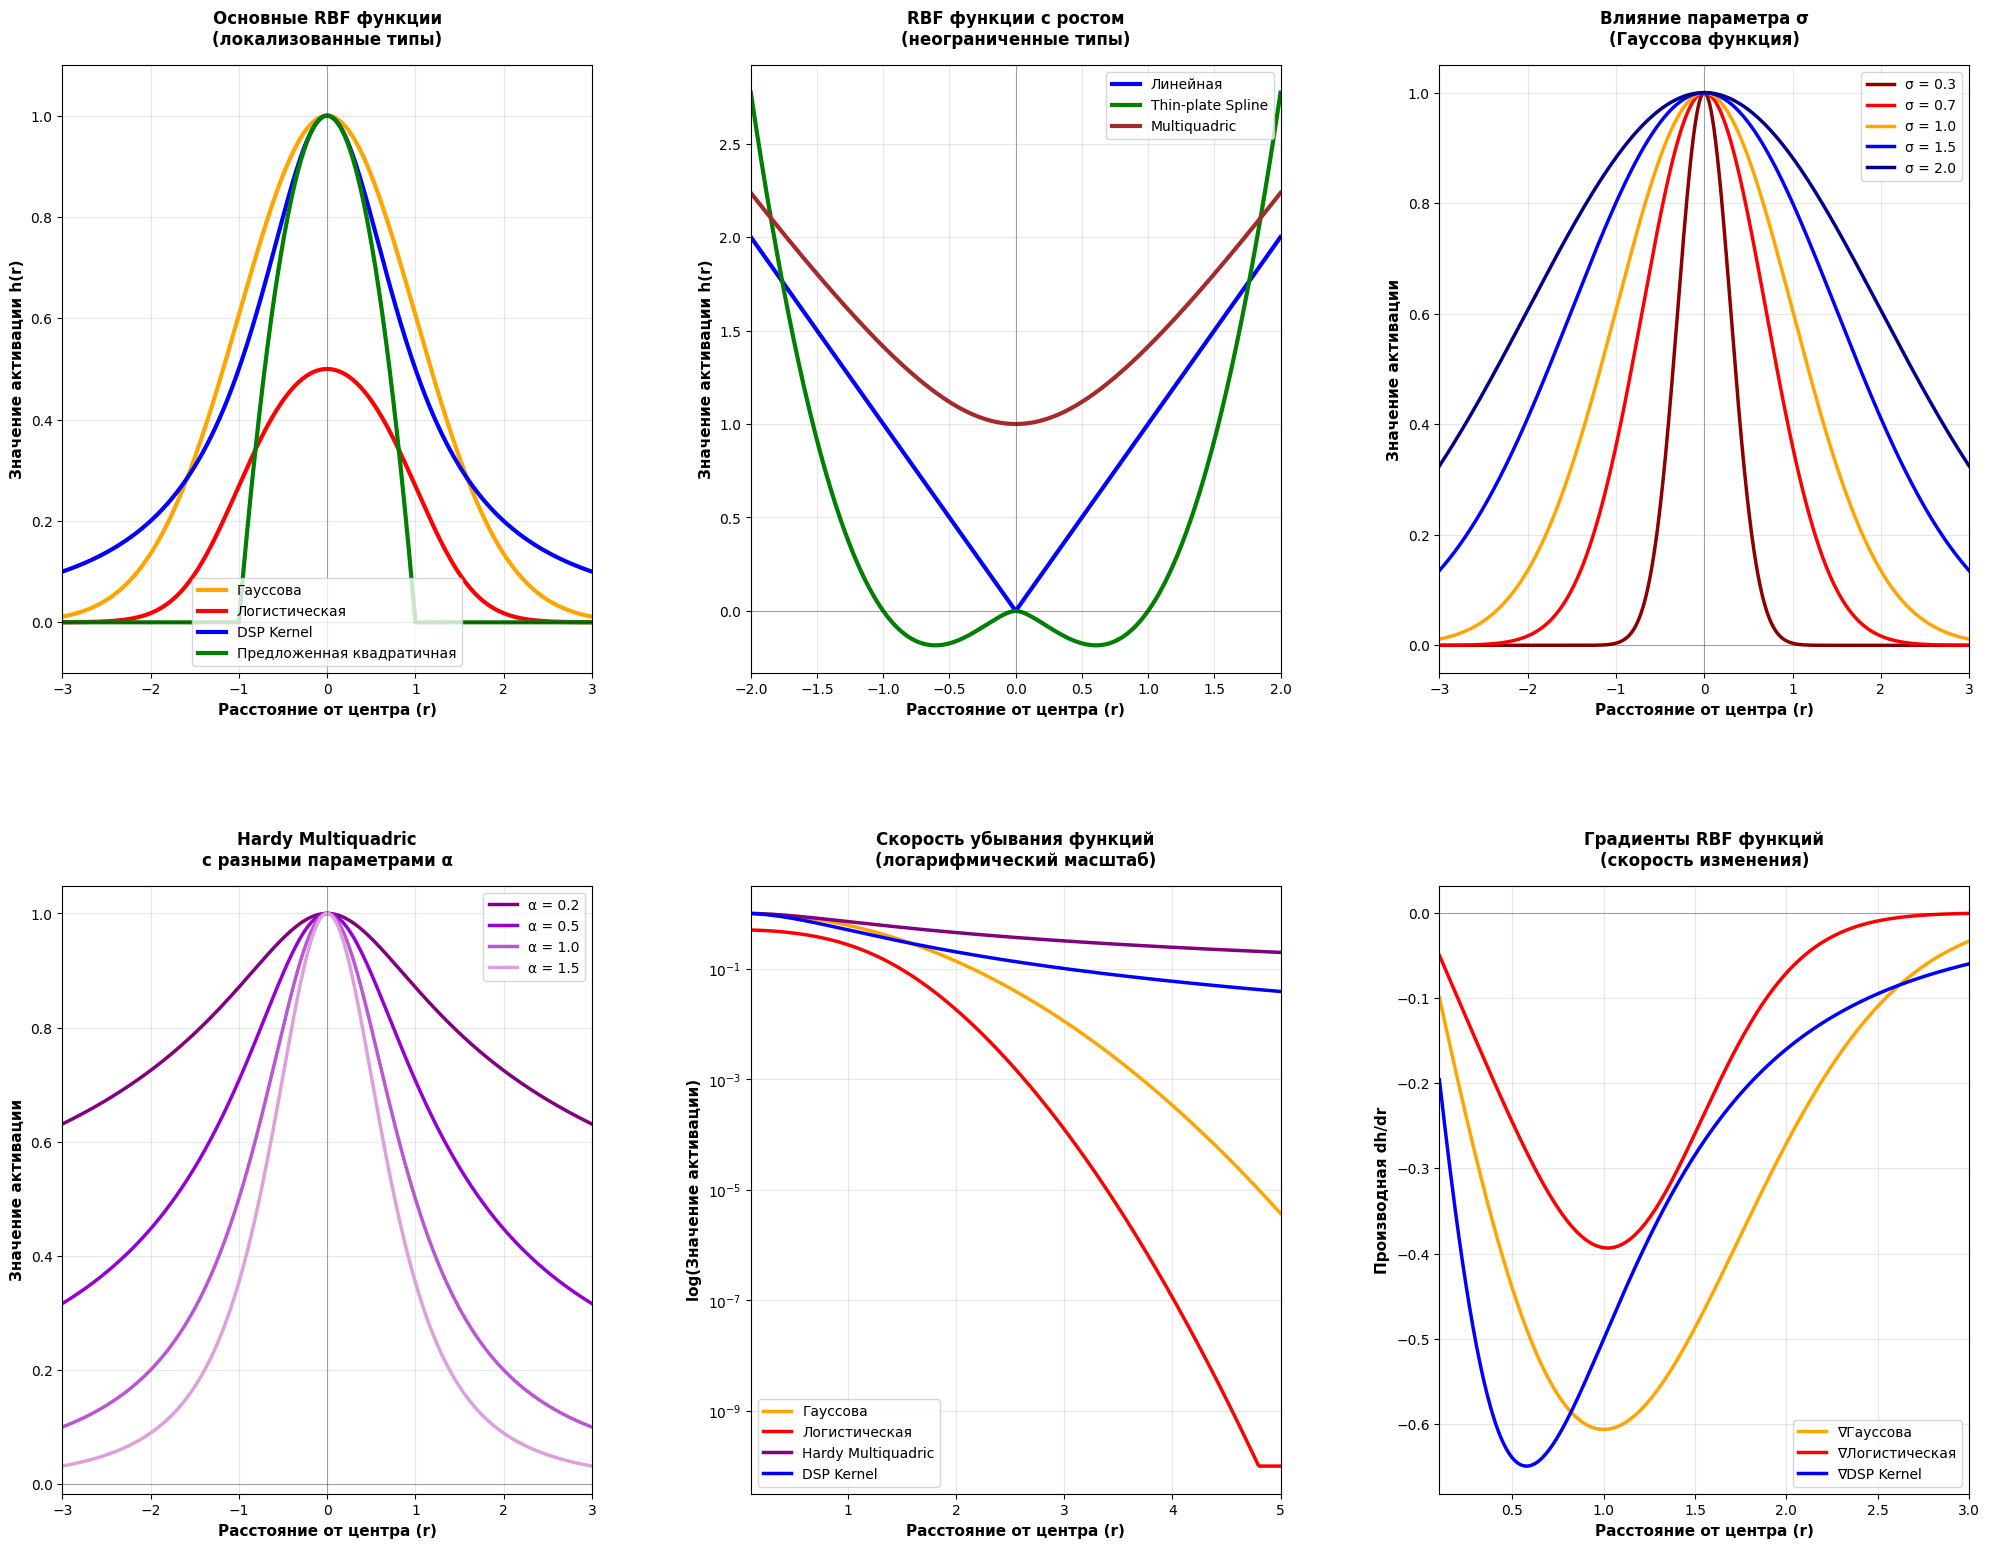


ПОДРОБНОЕ СРАВНЕНИЕ РАДИАЛЬНЫХ БАЗИСНЫХ ФУНКЦИЙ

1. ЛОКАЛИЗОВАННЫЕ ФУНКЦИИ (убывают с расстоянием):
------------------------------------------------------------
   Гауссова: h(r) = exp(-r²/2σ²)
   • Самая популярная в машинном обучении
   • Гладкая, бесконечно дифференцируемая
   • Быстро убывает к нулю
   • Хорошо подходит для аппроксимации гладких функций

   Логистическая: h(r) = 1/(1+exp(r²/σ²))
   • Ограничена между 0 и 1
   • Монотонно убывающая
   • Подходит для задач классификации
   • Вычислительно стабильная

   DSP Kernel: h(r) = 1/(1+r²/σ²)
   • Рациональная функция
   • Вычислительно эффективная
   • Хороший компромисс между локализацией и гладкостью

   Предложенная квадратичная: h(r) = max(0, 1-r²/σ²)
   • Компактный носитель (равна 0 за пределами σ)
   • Обеспечивает разреженность вычислений
   • Простая для вычисления

   Hardy Multiquadric: h(r) = 1/(r²+σ²)^α
   • Обратная мультиквадратичная функция
   • Численно стабильная
   • Параметр α контролирует скорость убыва

In [ ]:
import time

def main():
    """
    Главная функция для запуска демонстраций
    """
    print("==== Демонстрация работы радиально-базисных нейронных сетей ====")

    # Выберите демонстрации для запуска
    print("\nДоступные демонстрации:")
    print("1. Базовая демонстрация формирования RBF функций")
    print("2. Визуализация процесса обучения")
    print("3. Визуализация процесса обучения - интерактив")
    print("4. Эксперименты с количеством нейронов и шириной функций")
    print("5. Сравнение результатов на разных наборах данных")
    print("6. Расширенные эксперименты на сложных функциях")
    print("7. Сравнение различных типов радиальных базисных функций")

    try:
        choice = int(input("\nВыберите демонстрацию (введите число от 1 до 7): "))

        if choice == 1:
            print("\n--- БАЗОВАЯ ДЕМОНСТРАЦИЯ ФОРМИРОВАНИЯ RBF ФУНКЦИЙ ---")
            print("Показывает основные принципы построения радиально-базисных функций")
            print("Демонстрирует расположение центров и форму активационных функций")

            start_time = time.time()
            demo_rbf_formation()
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\nВремя выполнения: {execution_time:.3f} секунд")

        elif choice == 2:
            print("\n--- ВИЗУАЛИЗАЦИЯ ПРОЦЕССА ОБУЧЕНИЯ ---")
            print("Показывает пошаговое обучение РБНС и изменение весов")
            print("Демонстрирует, как сеть постепенно приближает целевую функцию")

            start_time = time.time()
            demo_training_process()
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\nВремя выполнения: {execution_time:.3f} секунд")

        elif choice == 3:
            print("\n--- ИНТЕРАКТИВНАЯ ВИЗУАЛИЗАЦИЯ ОБУЧЕНИЯ ---")
            print("Позволяет управлять процессом обучения в реальном времени")
            print("Показывает динамические изменения аппроксимации на каждом шаге")

            start_time = time.time()
            demo_training_process_interactive()
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\nВремя выполнения: {execution_time:.3f} секунд")

        elif choice == 4:
            print("\n--- ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ СЕТИ ---")
            print("Исследует влияние количества нейронов и ширины функций на качество")
            print("Демонстрирует оптимальный выбор архитектуры РБНС")

            start_time = time.time()
            demo_experiment_neurons_width()
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\nВремя выполнения: {execution_time:.3f} секунд")

        elif choice == 5:
            print("\n--- СРАВНЕНИЕ НА РАЗНЫХ НАБОРАХ ДАННЫХ ---")
            print("Показывает работу РБНС на различных типах функций и задач")
            print("Демонстрирует универсальность и ограничения метода")

            start_time = time.time()
            demo_dataset_comparison()
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\nВремя выполнения: {execution_time:.3f} секунд")

        elif choice == 6:
            print("\n--- РАСШИРЕННЫЕ ЭКСПЕРИМЕНТЫ ---")
            print("Тестирует РБНС на сложных многомерных и нелинейных функциях")
            print("Показывает возможности аппроксимации комплексных зависимостей")

            start_time = time.time()
            demo_advanced_experiments()
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\nВремя выполнения: {execution_time:.3f} секунд")

        elif choice == 7:
            print("\n--- ТЕОРЕТИЧЕСКОЕ СРАВНЕНИЕ RBF ФУНКЦИЙ ---")
            print("Показывает математические свойства и формы различных RBF функций")
            print("Каждая функция определяет, как нейрон реагирует на расстояние от центра")

            start_time = time.time()
            demonstrate_rbf_types()
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"\nВремя выполнения: {execution_time:.3f} секунд")

        else:
            print("Некорректный выбор. Пожалуйста, введите число от 1 до 7.")

    except ValueError:
        print("Пожалуйста, введите целое число от 1 до 7.")

if __name__ == "__main__":
    main()